<!-- Notes from meeting: 

actual arrest rate vs reported arrest rate (what we have)
 - some agencies not NIBRS-participating 
we do not not the police involvement rate 

think about how the ratios vary with different elements (size of reporting department)

if you look at reporting agency:

look at what percent of IPV incidents/total number of incidents reporting by agency and
do we have reason to believe this percent would change by agency (put the former race ratios in context)

theory: arrest rate by race (conditioned on offense type) should not vary with reporting department 

in presentation: emphasize - I have a code base, and I have a lot of flexibility in the sorts of questions I answer (i.e. in outlook talk about how my code base supports all the questions I could further ask)

1. I have a way to process the actual NIBRS data without ICPSR (can make tables akin to ICPSR or can make customizable tables)

2. can talk about some of the trade offs/decisions I had to make it creating the subset/filter

3. talk about performance of this framework: can talk about run-times/storage

4. give examples of the different types of analysis I can produce can run EDA about how reporting agencies differ, about how arrest rates differ

arc: I want to work with primary data and make my own decisions, how difficult is that? I have a result for this.  -->

<!-- This is quite a long notebook, simply because I utilized is as a journal and it shows many details of my thought process. I'm working on generating a more succinct version for documentation.  -->

![](NIBRSdiagram.png)

![](power-control-wheel-v2.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from random import sample, seed
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
global_start_time = time.time()

Some housekeeping:

In [3]:
# table style options
tablestyles = [{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px')
    ]
}]

In [4]:
# plot style options
from matplotlib import cycler
IPython_default = plt.rcParams.copy()
axisgrey = '#666565'
axisgrey2 = '#383838'
mycolors = ['#7a5195','#d04f89','#ff6959','#ffa600', '#228495','#00a17f','#83b138','#ffa600']
#mycolors = ['#7533bd', '#07ada7', '#de7ad4', '#d94e7a','#7ee6b7', '#66c464','#4287f5', '#b39bc9']
colors = cycler('color', mycolors)
plt.rc('axes', prop_cycle=colors, labelsize = 18, labelpad = 15, edgecolor = axisgrey )
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.color'] = axisgrey2
plt.rcParams['xtick.color'] = axisgrey2
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['legend.framealpha'] = 0
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rc('xtick', labelsize = 14)
plt.rc('ytick', labelsize = 14)
#plt.rc('font', family = 'DejaVu Sans')
#plt.rcParams.keys()

In [5]:
# makeshift progress bar
def printprogress(i, n, start_time, step = 10):
    t = time.time() - start_time
    if i == n-1:
        print("100 %% -- %d minutes %f seconds"%(math.floor(t/60),t%60))
    if (i<(n-1)-n%step) & (i%math.floor(n/step) == 0):
        print("%d %% -- %d minutes %f seconds"%((i+1)/math.floor((n-1)/step)*step, math.floor(t/60),t%60))

In [6]:
folder = "TX-2019/TX/" #location of data tables


## Reporting agencies

Load data table: *agencies.csv* - contains information about the agencies (e.g. police departments) that reported the data in TX2019

In [7]:
agencies = pd.read_csv(folder + "agencies.csv")
#agencies.columns

Data dictionary for variables in *agencies.csv*

In [8]:
df = pd.read_csv(folder + "agency_data_dictionary.csv").set_index('Variable Name')
df = df.reindex(agencies.columns.to_list()).fillna(' ') # only show defs for variables in agencies.csv
 
# display(df.style.set_table_styles([dict(selector="th",props=[('max-width', '999px')])]))
# with pd.option_context("max_colwidth", 1000):
#     latex = df.to_latex(longtable = True, escape = False, buf = 'latex.txt')

`SUMMARY_RAPE_DEF` indicates the **definition of rape used by the agency**, taking on values "L" for legacy and "R" for revised (word "forcible" in SRS and words "forcibly or against the victim's will" in NIBRS replaced with "without the victims consent," [see more](https://ucr.fbi.gov/nibrs/2013/resources/nibrs-rape-vs.-srs-rape#:~:text=%E2%80%A2%20Sexual%20Assault%20With%20An,of%20his%2Fher%20age%20or)). Because this is relevant to IPV, it is important I know the definition of rape that was used in reporting the data. 

See below that all reporting agencies in TX-2019 data used the revised definition. This variable would perhaps be a more important consideration if I considered using previous years of NIBRS data since the revision occurred in 2013.

In [9]:
agencies['SUMMARY_RAPE_DEF'].value_counts()

R    621
Name: SUMMARY_RAPE_DEF, dtype: int64

<br>

Though *agencies.csv* includes the variable `NIBRS_PARTICIPATED`, all agencies for TX-2019 are NIBRS-participating

In [10]:
print("no. agencies listed:\n",len(agencies['AGENCY_ID'].unique()))
print("no. agenices listed where NIBRS_PARTICIPATED = Y:\n",len(agencies.loc[agencies['NIBRS_PARTICIPATED']=='Y']))

no. agencies listed:
 621
no. agenices listed where NIBRS_PARTICIPATED = Y:
 621


In [11]:
len(agencies['COUNTY_NAME'].unique())

262

There are 262 unique values for `COUNTY_NAME` in agencies.csv, but only 254 counties in Texas.

This is actually the result of some agencies covering multiple counties. For example, the Houston Police Department `NCIC_AGENCY_NAME = HOUSTON POLICE DEPARTMANT` covers three counties `COUNTY_NAME = MONTOGMERY;FORT BEND;HARRIS`. If I account for this, there are actually **212 counties** in TX covered by agencies participating in NIBRS. See code below. 

In [12]:
multicounty = []
singlecounty = []
for each in agencies['COUNTY_NAME'].unique():
    if each.find(";")!=-1:
        multicounty.append(each)
    else:
        singlecounty.append(each)
        
county_list = np.asarray([])
for counties in multicounty:
    temp = counties.split("; ")
    county_list = np.hstack([county_list, temp])
county_list = np.hstack([county_list, singlecounty])

print("no. of counties: ", len(np.unique(county_list)))
#print(np.unique(county_list)) ## print list of counties

no. of counties:  212


<br>

<a id='harris_agencies'></a>
See below how *agencies.csv* can be used to look at specific reporting agencies, or in this example, **agencies in Harris County**

In [13]:
agencies.loc[agencies['COUNTY_NAME']=='HARRIS'][np.array(("NCIC_AGENCY_NAME", "PUB_AGENCY_NAME", "NIBRS_START_DATE", "POPULATION", "POPULATION_GROUP_DESC","AGENCY_TYPE_NAME", "COUNTY_NAME"))]

,NCIC_AGENCY_NAME,PUB_AGENCY_NAME,NIBRS_START_DATE,POPULATION,POPULATION_GROUP_DESC,AGENCY_TYPE_NAME,COUNTY_NAME
233,DEER PARK PD,Deer Park,01-OCT-19,34167,"Cities from 25,000 thru 49,999",City,HARRIS
234,JERSEY VILLAGE PD HOUSTON,Jersey Village,01-SEP-19,8006,"Cities from 2,500 thru 9,999",City,HARRIS
235,LA PORTE PD,La Porte,01-OCT-19,35622,"Cities from 25,000 thru 49,999",City,HARRIS
236,PASADENA PD,Pasadena,01-JAN-19,153689,"Cities from 100,000 thru 249,999",City,HARRIS
237,SEABROOK PD,Seabrook,01-OCT-19,14611,"Cities from 10,000 thru 24,999",City,HARRIS
238,SOUTH HOUSTON PD,South Houston,01-MAY-11,17655,"Cities from 10,000 thru 24,999",City,HARRIS
239,SOUTH SIDE PLACE PD HOUSTON,Southside Place,01-JUN-18,1902,"Cities under 2,500",City,HARRIS
240,SPRING VALLEY VILLAGE POLICE DEPARTMENT,Spring Valley,01-JUL-18,4414,"Cities from 2,500 thru 9,999",City,HARRIS
241,TOMBALL PD,Tomball,01-APR-06,11897,"Cities from 10,000 thru 24,999",City,HARRIS
243,NASSAU BAY POLICE DEPARTMENT,Nassau Bay,01-OCT-19,4040,"Cities from 2,500 thru 9,999",City,HARRIS


What types of agencies in TX are represented in the data?

It's also relevent to consider the number of incidents reported per agency. The problem in recreating the plots from last semester is that the `CORE_CITY` flag in the ICPSR distribution of NIBRS 2016 data is not in the agencies.csv file with the TX-2019 download. I can explore this a little by merging incident reports with agency data on `AGENCY_ID`.

Load table: *NIBRS_incident.csv*

In [14]:
NIBRS_incident = pd.read_csv(folder+"NIBRS_incident.csv")
#NIBRS_incident.columns
tot_no_incidents = len(NIBRS_incident['INCIDENT_ID'].unique())
print("Total no. of incidents in NIBRS-TX2019: ", tot_no_incidents)

Total no. of incidents in NIBRS-TX2019:  901223


Can't find documentation for `INCIDENT_STATUS`. All instances in NIBRS_incident.csv have an `INCIDENT_STATUS` value of 0, so not very relevant at least for right now. Closet I've found to it is [page 34 here](https://www.oregon.gov/osp/Docs/ONIBRS%20System%20Specification%20V3.5.pdf) but that only gives the codes as letters and not as integers.

In [15]:
# merge incident data table with agency data table using 'AGENCY_ID'
ag_incident = pd.merge(right = NIBRS_incident,
                   left = agencies,
                   on = ["DATA_YEAR", "AGENCY_ID"], 
                   #how = "inner"    # default
                   )

In [16]:
#ag_incident.columns

A little bit of exploring revealed that there are more unique identifiers using `AGENCY_ID` than using agency name variables like `UCR_AGENCY_NAME`, `NCIC_AGENCY_NAME`, `PUB_AGENCY_NAME`/ `PUB_AGENCY_UNIT`, but there is the same number of unique identifiers for `ORI`. That is, not every agency given a unique agency ID (or, equivalently, ORI) has a unique UCR agency name, NCIC agency name, etc. 

Below I generate a new variable `NUMINC` for each unique `AGENCY_ID` the holds the count of the number of incidents reported by that agency. 

In [17]:
inc_counts = ag_incident["AGENCY_ID"].value_counts() # counts the number of incidents associated with an agency ID
inc = pd.DataFrame(inc_counts.values, index = inc_counts.index, columns = ["NUMINC"])

## merge with other agency info
inc = pd.merge(left = inc, left_index = True, right = agencies, right_on = 'AGENCY_ID')
#len(inc['COUNTY_NAME'].unique()) # is equal to that for all agencies in agencies file

In [18]:
inc["AGENCY_TYPE_NAME"].value_counts()

## How many agencies per each type of population group? - index used to manually sort
# agencies["POPULATION_GROUP_DESC"].value_counts()[[1,0,2,4,6,8,12,14,15,3,5,10,9,11,7, 13]]

## How many agencies per each type of parent population group? - index used to manually sort
# agencies["PARENT_POP_GROUP_DESC"].value_counts()[[1,0,3,5,6,7,8,2,4]]

City                     423
County                   134
Other                     32
University or College     30
Name: AGENCY_TYPE_NAME, dtype: int64

Number of reporting agencies:  619


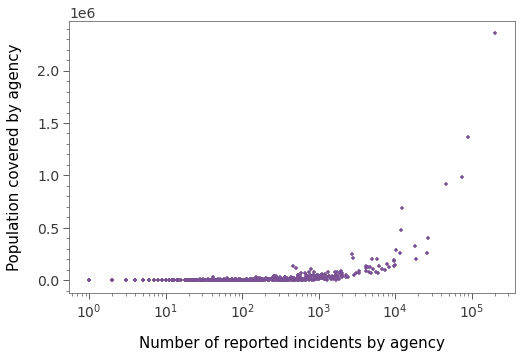

In [19]:
fig, ax = plt.subplots(figsize = (8,5))
ax.scatter(inc["NUMINC"], inc["POPULATION"], s = 10, marker = "+")
ax.set_xlabel("Number of reported incidents by agency", fontsize = 15, labelpad = 15)
ax.set_ylabel("Population covered by agency", fontsize = 15, labelpad = 15)
print("Number of reporting agencies: ", len(inc))
ax.set_xscale('log')

What are the outliers? `PROP_INC` created to show the fraction of all incidents in the data reported by that agency. 

In [20]:
inc['PROP_INC'] = inc['NUMINC']/tot_no_incidents
hold = inc.sort_values(axis = 0, by = "NUMINC", ascending = False)[0:10][["NUMINC", "PROP_INC", "NCIC_AGENCY_NAME","COUNTY_NAME", "NIBRS_START_DATE"]]
display(hold)
latex = hold.to_latex(longtable = False, escape = False, buf = 'latex.txt')
print("%.2f %% of all incidents are reported by these top ten highest-reporting agencies"%(sum(hold['PROP_INC'])*100))

,NUMINC,PROP_INC,NCIC_AGENCY_NAME,COUNTY_NAME,NIBRS_START_DATE
574,202581,0.224785,HOUSTON POLICE DEPARTMENT,MONTGOMERY; FORT BEND; HARRIS,01-JUN-18
573,90375,0.100280,DALLAS POLICE DEPARTMENT,DENTON; COLLIN; DALLAS,01-MAR-18
512,73972,0.082080,AUSTIN PD,WILLIAMSON; TRAVIS,01-JAN-19
489,46241,0.051309,FORT WORTH PD,PARKER; DENTON; TARRANT,01-OCT-05
483,27243,0.030229,ARLINGTON PD,TARRANT,01-FEB-16
347,25833,0.028664,LUBBOCK PD,LUBBOCK,01-OCT-17
428,18568,0.020603,AMARILLO PD,RANDALL; POTTER,01-OCT-99
403,17930,0.019895,CORPUS CHRISTI PD,NUECES,01-MAY-19
179,12131,0.013461,EL PASO PD,EL PASO,01-JUL-19
188,11828,0.013124,FORT BEND CO SO RICHMOND,FORT BEND,01-JUN-18


58.44 % of all incidents are reported by these top ten highest-reporting agencies


The previous figure shows a pretty linear relationship between population covered by an agency and the number of incidents reported by that agency. What is the correlation coefficient between the two? What about correlation with the number of people employed by that agency, like the number of male/female officers or the number of total male/female employees (i.e. officers and civilians)?

In [21]:
print("Correlation matrix:")
inc[['NUMINC', 'POPULATION', 'MALE_OFFICER', 'FEMALE_OFFICER', 'MALE_CIVILIAN', 'FEMALE_CIVILIAN', 'PED.MALE_OFFICER+PED.MALE_CIVILIAN', 'PED.FEMALE_CIVILIAN+PED.FEMALE_OFFICER']].corr()

Correlation matrix:


,NUMINC,POPULATION,MALE_OFFICER,FEMALE_OFFICER,MALE_CIVILIAN,FEMALE_CIVILIAN,PED.MALE_OFFICER+PED.MALE_CIVILIAN,PED.FEMALE_CIVILIAN+PED.FEMALE_OFFICER
NUMINC,1.000000,0.958039,0.977120,0.966915,0.367590,0.732795,0.943237,0.901168
POPULATION,0.958039,1.000000,0.987091,0.959802,0.431486,0.799841,0.965904,0.935607
MALE_OFFICER,0.977120,0.987091,1.000000,0.982373,0.448684,0.803540,0.981042,0.949042
FEMALE_OFFICER,0.966915,0.959802,0.982373,1.000000,0.393981,0.748311,0.953602,0.926585
MALE_CIVILIAN,0.367590,0.431486,0.448684,0.393981,1.000000,0.849769,0.613371,0.679685
FEMALE_CIVILIAN,0.732795,0.799841,0.803540,0.748311,0.849769,1.000000,0.894396,0.942850
PED.MALE_OFFICER+PED.MALE_CIVILIAN,0.943237,0.965904,0.981042,0.953602,0.613371,0.894396,1.000000,0.986100
PED.FEMALE_CIVILIAN+PED.FEMALE_OFFICER,0.901168,0.935607,0.949042,0.926585,0.679685,0.942850,0.986100,1.000000


Number of incidents for a given agency (NUMINC) and the variables for population and number of agency employees shown above are all strongly correlated with each other. Variables that have strongest correlation with number of incidents per agency are number of male officers employed  ($r = 0.977$) and number of female officers employed ($r = 0.967)$. 

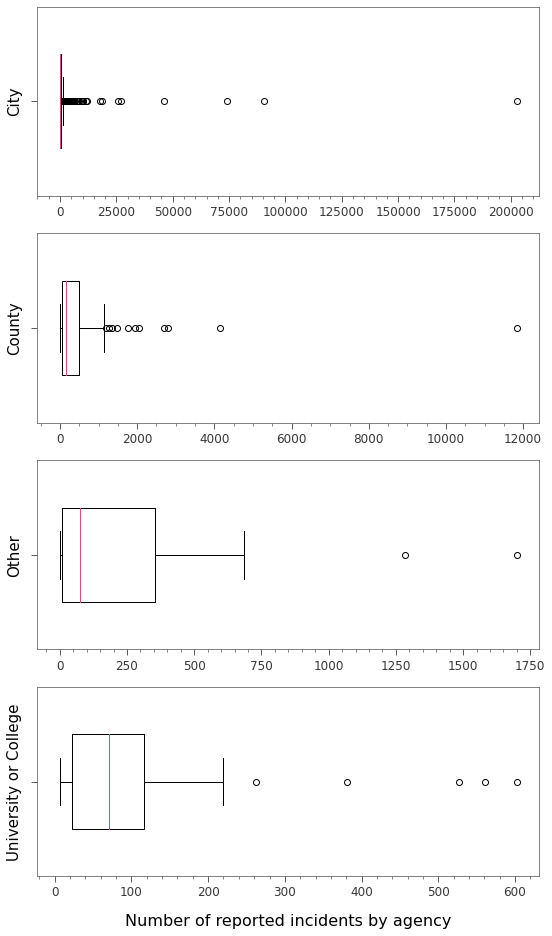

In [22]:
c = "AGENCY_TYPE_NAME"
n = len(inc[c].unique())
fig, axes = plt.subplots(n, figsize = (9, 4*n), sharex = False)
for i, each in enumerate(inc[c].unique()):
    axes[i].boxplot(inc.loc[inc[c]==each]["NUMINC"], vert = False, widths = 0.5)
    axes[i].set_ylabel(each, fontsize = 15)
    axes[i].tick_params(labelleft= False, labelsize = 12)
    
_ = axes[n-1].set_xlabel("Number of reported incidents by agency", fontsize = 16)

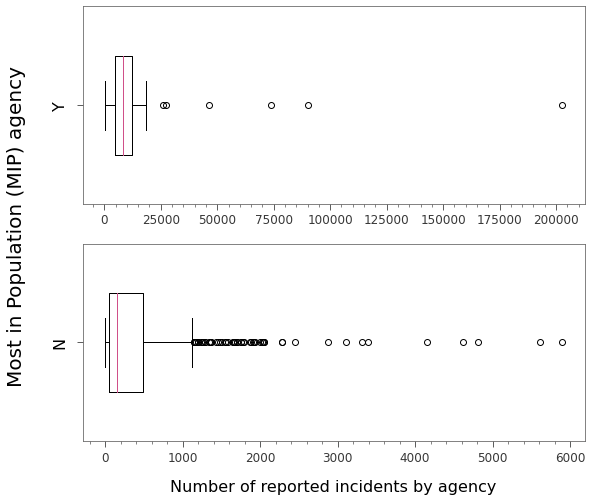

In [23]:
c = "MIP_FLAG" # indicates if an agency is a Most in Population agency (over 100,000)
n = len(inc[c].unique())
fig, axes = plt.subplots(n, figsize = (9, 4*n), sharex = False)
for i, each in enumerate(inc[c].unique()):
    axes[i].boxplot(inc.loc[inc[c]==each]["NUMINC"], vert = False, widths = 0.5)
    axes[i].set_ylabel(each, fontsize = 16)
    axes[i].tick_params(labelleft= False, labelsize = 12)
    
axes[n-1].set_xlabel("Number of reported incidents by agency", fontsize = 16)
_ = axes[0].text(-0.15,-0.9, "Most in Population (MIP) agency", transform = axes[0].transAxes, fontsize = 20, rotation = 90)

median: 0.026675 


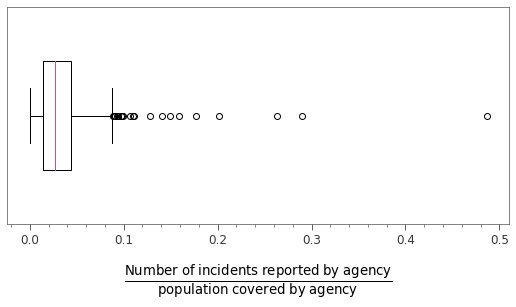

In [24]:
fig, ax = plt.subplots(figsize = (9,4))
boxplot =  ax.boxplot(inc.loc[inc['POPULATION']!=0]['NUMINC']/inc.loc[inc['POPULATION']!=0]['POPULATION'], vert = False, widths = 0.5)
ax.tick_params(left = False, labelleft = False, labelsize = 12)
_ = ax.set_xlabel(r"$\frac{\mathrm{Number\;of\;incidents\;reported\;by\;agency}}{\mathrm{population\;covered\;by \;agency}}$", fontsize = 19, labelpad = 15)
print("median: %f "%boxplot['medians'][0].get_xdata()[0])

#plt.savefig('Figures/agencies_normpart_boxplot', bbox_inches = 'tight')

In [25]:
print("Median no. of incidents reported by an agency", 
      inc[['AGENCY_ID','NUMINC']].drop_duplicates()['NUMINC'].median())
print("Mean no. of incidents reported by an agency", 
      inc[['AGENCY_ID','NUMINC']].drop_duplicates()['NUMINC'].mean())

Median no. of incidents reported by an agency 172.0
Mean no. of incidents reported by an agency 1455.9337641357029


# Assembling Data: 
## 1. Victim-offender relationship records

NIBRS_VICTIM_OFFENDER_REL.csv has columns `DATA_YEAR`,`VICTIM_ID`,`OFFENDER_ID`,`RELATIONSHIP_ID`,and `NIBRS_VICTIM_OFFENDER_ID`.

The values for `RELATIONSHIP_ID` are included in NIBRS_RELATIONSHIP.csv (see below)


**Codes/descriptions for `RELATIONSHIP_ID`**

In [26]:
#pandas.set_option('display.max_rows', None)
rel_types = pd.read_csv(folder+"NIBRS_RELATIONSHIP.csv")
#display(rel_types)
## dictionary that converts RELATIONSHIP_ID -> RELATIONSHIP_NAME
drel_types = dict(zip(rel_types['RELATIONSHIP_ID'].to_list(),rel_types['RELATIONSHIP_NAME'].to_list()))
#drel_types[21]

Load table: *NIBRS_VICTIM_OFFENDER_REL.csv*

In [27]:
vict = pd.read_csv(folder+"NIBRS_VICTIM_OFFENDER_REL.csv")
#vict.columns

In [28]:
# summary 
relcounts = vict['RELATIONSHIP_ID'].value_counts()
temp = pd.merge(right = pd.DataFrame(np.array([relcounts.index.to_list(), relcounts.values, relcounts.values/sum(relcounts)*100]).T, \
                              columns = ['RELATIONSHIP_ID', 'n', '(%)']), 
         left = rel_types[['RELATIONSHIP_ID', 'RELATIONSHIP_NAME']], 
         on = 'RELATIONSHIP_ID'
)[['RELATIONSHIP_NAME', 'n', '(%)']].astype({'n':np.int64})\
.sort_values(by = 'n', ascending = False)
display(temp\
.style.set_table_styles([dict(selector="th",props=[('max-width', '999px')])]))
temp.to_latex(buf = 'latex.txt', index = False, longtable = True, float_format = "%.2f", 
              caption = 'Victim and offender relationship type summary for all TX2019 data')

,RELATIONSHIP_NAME,n,(%)
18,Relationship Unknown,70774,20.045317
24,Victim Was Stranger,61679,17.469340
1,Victim Was Acquaintance,45754,12.958903
3,Victim Was Boyfriend/Girlfriend,42109,11.926530
15,Victim Was Other Family Member,26104,7.393435
21,Victim Was Spouse,19824,5.614751
16,Victim was Otherwise Known,13844,3.921035
17,Victim Was Parent,11016,3.120061
25,Victim Was Offender,10113,2.864305
19,Victim Was Sibling,9554,2.705979


## 2. Connect victims to offenses
- NIBRS_VICTIM_OFFENDER_REL.csv contains `VICTIM_ID`
- NIBRS_VICTIM_OFFENSE contains both `VICTIM_ID` and `OFFENSE_ID`
- retain `OFFENDER_ID` from NIBRS_VICTIM_OFFENDER_REL.csv so I can get information on offender later

**Codes/descriptions for `OFFENSE_TYPE_ID`**

In [29]:
offense_types = pd.read_csv(folder+"NIBRS_OFFENSE_TYPE.csv")
#display(offense_types)
## dictionary that converts OFFENSE_TYPE_ID -> OFFENSE_NAME
doffense_types = dict(zip(offense_types['OFFENSE_TYPE_ID'].to_list(),offense_types['OFFENSE_NAME'].to_list()))
#doffense_types[2]

Load table: *NIBRS_VICTIM_OFFENSE.csv*

In [30]:
NIBRS_victim_offense = pd.read_csv(folder+"NIBRS_VICTIM_OFFENSE.csv")
#NIBRS_victim_offense.columns

From the README: 

*This table maps victims to offenses and should be used to get all
victims of a specific offense associated with an incident. Do not
simply assume that all offenses associated with an incident apply to all victims.*

`OFFENSE_ID` can be matched to multiple values of `VICTIM_ID`, i.e. this is a "many-to-one" join.

I can use `how = 'right'` to ensure that each victim in my list of IP victim-offender relationships is matched with an offense. I tried it both ways and it doesn't matter whether `how = 'inner'` or `how = 'right'` is used. 

In [31]:
vict_offense = pd.merge(left = NIBRS_victim_offense, 
                        #right = IPvict,
                        right = vict,
                        on = ['VICTIM_ID', 'DATA_YEAR'],
                        how = 'right',
)
#print(len(vict_offense))
#vict_offense.columns

The following shows that the join is not one-to-one (i.e. more offense records that victim-offender relationship records). 

In [32]:
print("no. of relationship records in TX: ", len(vict))
print("no. of offense records associated with relationship between victim-offender: ",len(vict_offense))


no. of relationship records in TX:  353070
no. of offense records associated with relationship between victim-offender:  368722



Connect this new dataframe to the NIBRS_OFFENSE.csv using `OFFENDER_ID`:

Load table: *NIBRS_offense.csv*

In [33]:
NIBRS_offense = pd.read_csv(folder+"NIBRS_offense.csv")
#NIBRS_offense.columns

In [34]:
# summary for all TX-2019
offncounts = NIBRS_offense['OFFENSE_TYPE_ID'].value_counts()
temp = pd.merge(right = pd.DataFrame(np.array([offncounts.index.to_list(), offncounts.values, offncounts.values/sum(offncounts)*100]).T, \
                              columns = ['OFFENSE_TYPE_ID', 'n', '(%)']), 
         left = offense_types[['OFFENSE_TYPE_ID', 'OFFENSE_NAME']], 
         on = 'OFFENSE_TYPE_ID'
)[['OFFENSE_NAME', 'n', '(%)']].astype({'n':np.int64})\
.sort_values(by = 'n', ascending = False)
display(temp.style.set_table_styles([dict(selector="th",props=[('max-width', '999px')])]))
temp.to_latex(buf = 'latex.txt', index = False, longtable = True, float_format = "%.2f", 
              caption = 'Offense type summary for all TX2019 data')

,OFFENSE_NAME,n,(%)
46,Simple Assault,141754,14.662200
34,All Other Larceny,113451,11.734704
10,Theft From Motor Vehicle,106628,11.028973
4,Destruction/Damage/Vandalism of Property,93105,9.630233
12,Drug/Narcotic Violations,80327,8.308552
36,Burglary/Breaking & Entering,66940,6.923880
17,Shoplifting,50628,5.236662
16,Motor Vehicle Theft,48495,5.016037
20,Aggravated Assault,39900,4.127021
33,Intimidation,38148,3.945805


In [35]:
vict_offns = pd.merge(left = NIBRS_offense, 
                     right = vict_offense, 
                     on = ['DATA_YEAR','OFFENSE_ID'])
#print(len(vict_offns))
#vict_offns.columns

As expected, comparison of dataframe sizes showed this merge just added additional information (columns) about the offense, including most notably `OFFENSE_TYPE_ID`.

## 3. Add Victim and Offender information (e.g., age, sex, race)
- merge on `VICTIM_ID` and `INCIDENT_ID`
- merge on `OFFENDER_ID` and `INCIDENT_ID`

Load table: *NIBRS_victim.csv*

In [36]:
NIBRS_victim = pd.read_csv(folder+"NIBRS_victim.csv")
#NIBRS_victim.columns

Load table: *NIBRS_offender.csv*

In [37]:
NIBRS_offender = pd.read_csv(folder + "NIBRS_offender.csv")
#NIBRS_offender.columns

The same variable names `AGE_ID`, `AGE_NUM`, `SEX_CODE`, `RACE_ID`, `ETHNICITY_ID`, `AGE_RANGE_LOW_NUM`, `AGE_RANGE_HIGH_NUM` are used in both *NIBRS_victim.csv* and *NIBRS_offender.csv*

So I'll have to rename the variables before merging. 

In [38]:
## rename victim and offender variables
vmap = {}
omap = {}
for each in ['AGE_ID', 'AGE_NUM', 'SEX_CODE', 'RACE_ID', 'ETHNICITY_ID', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']:
    vmap[each] = 'VICTIM_'+each
    omap[each] = 'OFFENDER_'+each

NIBRS_victim2 = NIBRS_victim.rename(columns = vmap)
#print(NIBRS_victim2.columns)
NIBRS_offender2 = NIBRS_offender.rename(columns = omap)
#NIBRS_offender2.columns

Merge with victim and offender info:

In [39]:
### merge with victim info
VO1 = pd.merge(left = vict_offns,
              right = NIBRS_victim2, 
              on = ['DATA_YEAR', 'VICTIM_ID', 'INCIDENT_ID'])
#print("in previous dataset, n = ", len(vict_offns))
#print("in new dataset, n = ", len(VO1))
#print(VO1.columns)

### merge with offender info
VO2 = pd.merge(left = VO1, 
              right = NIBRS_offender2, 
              on = ['DATA_YEAR', 'OFFENDER_ID', 'INCIDENT_ID'])
#print("in new dataset, n = ",len(VO2))
#print(VO2.columns)

Something different from the ICPSR distribution is that **age is given via two variables as a range** instead of being given as a single value. I don't expect this to be an issue since I'm dealing with intimate partner relationships. Here's what `AGE_ID` corresponds to:

In [40]:
pd.read_csv(folder + "NIBRS_AGE.csv")

,AGE_ID,AGE_CODE,AGE_NAME
0,1,NN,Under 24 Hours
1,2,NB,1-6 Days Old
2,3,BB,7-364 Days Old
3,4,00,Unknown
4,5,AG,Age in Years
5,6,99,Over 98 Years Old
6,0,NS,Not Specified


If the age is known , it's given by `AGE_RANGE_LOW_NUM` or, equivalently, `AGE_NUM`. If `AGE_ID` is anything other than 5, `AGE_NUM`,`AGE_RANGE_LOW_NUM`, and `AGE_RANGE_HIGH_NUM` are all NaN. If `AGE_ID` is 5, `AGE_RANGE_HIGH_NUM` can be either 0 (if exact age is known) or greater than `AGE_RANGE_LOW_NUM` (thus giving an age range). 

In [41]:
NIBRS_victim[["AGE_ID", 'AGE_NUM','AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']][0:10]

,AGE_ID,AGE_NUM,AGE_RANGE_LOW_NUM,AGE_RANGE_HIGH_NUM
0,5.0,35.0,35.0,0.0
1,5.0,25.0,25.0,0.0
2,5.0,57.0,57.0,0.0
3,5.0,34.0,34.0,0.0
4,5.0,37.0,37.0,0.0
5,5.0,47.0,47.0,0.0
6,5.0,63.0,63.0,0.0
7,NaN,NaN,NaN,NaN
8,5.0,79.0,79.0,0.0
9,5.0,27.0,27.0,0.0


In [42]:
NIBRS_victim[["AGE_ID",'AGE_NUM', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']].loc[NIBRS_victim['AGE_RANGE_HIGH_NUM']>0][0:10]

,AGE_ID,AGE_NUM,AGE_RANGE_LOW_NUM,AGE_RANGE_HIGH_NUM
375,5.0,58.0,18.0,99.0
1132,5.0,62.0,60.0,65.0
1454,5.0,38.0,12.0,65.0
2889,5.0,44.0,40.0,49.0
2924,5.0,15.0,15.0,16.0
3257,5.0,9.0,1.0,17.0
3917,5.0,58.0,17.0,99.0
4060,5.0,60.0,21.0,99.0
4268,5.0,15.0,10.0,20.0
4445,5.0,68.0,67.0,70.0


If an age range is given (i.e. exact age is NOT known), then `AGE_NUM` is given as the midpoint of the range, rounding down to the nearest whole integer, i.e. 
```
if AGE_RANGE_HIGH_NUM>0:
    `AGE_NUM` = math.floor( (AGE_RANGE_LOW_NUM + AGE_RANGE_HIGH_NUM)/2 )
```

Below I create variables `VICTIM_AGE` and `OFFENDER_AGE` to simplify things a bit further: these variables give the age as a single value if age is known, and -99 otherwise. I do this because I assume that the ages of the victim(s)/offender(s) will be known in a large majority of -- if not all -- IPV incidents. 

In [43]:
VO2['OFFENDER_AGE'] = np.where((VO2['OFFENDER_AGE_ID']==5)&(VO2['OFFENDER_AGE_RANGE_HIGH_NUM']==0), 
                               VO2['OFFENDER_AGE_RANGE_LOW_NUM'], 
                              -99)

VO2['VICTIM_AGE'] = np.where((VO2['VICTIM_AGE_ID']==5)&(VO2['VICTIM_AGE_RANGE_HIGH_NUM']==0), 
                               VO2['VICTIM_AGE_RANGE_LOW_NUM'], 
                              -99)

## 4. Merge with incident data

The arrestee data is connected with `INCIDENT_ID`, so in order to get information on whether or not an arrest occurred, I must merge the offense data with incident data. 

In [44]:
## double check I didn't miss any variables present in both VO2 and NIBRS_incident
# for each in VO2.columns.to_list():
#     if each in NIBRS_incident.columns.to_list():
#         print(each)

In [45]:
# IVO = incident, victim, offender
IVO = pd.merge(left = NIBRS_incident, 
        right = VO2, 
        on = ['DATA_YEAR', 'INCIDENT_ID'],
        how = "inner") # how = 'right' produces the same result
#print(len(vict_offns))
#print(len(IVO))
#IVO.columns

Now I have to figure out how to address this:

In [46]:
print("number of rows in dataset: ",len(IVO))
print("number of unique incidents in dataset: ",len(IVO['INCIDENT_ID'].unique()))

number of rows in dataset:  368722
number of unique incidents in dataset:  245295


I'll create a variable (`INC_APPEARS`) to indicate how many times the incident ID is repeated in the current dataset and then explore. 

In [47]:
nappears = IVO['INCIDENT_ID'].value_counts()
temp = pd.DataFrame(nappears.values, index = nappears.index, columns = ['INC_APPEARS'])
IVO = pd.merge(left = IVO, right = temp, right_index = True, left_on = 'INCIDENT_ID', how = 'inner')
#print(len(IVO))

In [48]:
print("How many incident_id's (count) appear (X) times?\n")
print("%.10s %11s\n---------------"%('X', 'count'))
print(IVO[['INCIDENT_ID', 'INC_APPEARS']].drop_duplicates()['INC_APPEARS'].value_counts(normalize = False))

How many incident_id's (count) appear (X) times?

X       count
---------------
1       188615
2        33453
4        10486
3         6789
6         2487
8          870
5          791
9          435
12         370
10         284
16         132
7          130
15         106
20          75
24          53
18          52
14          42
25          19
21          17
30          16
36           8
32           8
28           8
27           7
11           5
22           4
40           4
42           4
49           4
48           3
17           2
35           2
60           2
46           1
129          1
58           1
57           1
44           1
45           1
64           1
41           1
1035         1
13           1
33           1
81           1
Name: INC_APPEARS, dtype: int64


The majority of incidents only appear once, but some appear multiple times (i.e. due to multiple victims or offenses).

Let's look at some examples where `INC_APPEARS` $>1$

#### Example 1

In [49]:
colselect = ['INCIDENT_ID', 'OFFENSE_TYPE_ID', 'LOCATION_ID', 'VICTIM_ID', 'OFFENDER_ID', 
             'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_AGE', 'VICTIM_SEX_CODE', 
            'OFFENDER_AGE', 'OFFENDER_SEX_CODE', 'INC_APPEARS']

location_types = pd.read_csv(folder+"NIBRS_LOCATION_TYPE.csv")
dlocation_type = dict(zip(location_types["LOCATION_ID"], location_types['LOCATION_NAME']))
IVO[colselect].loc[IVO['INCIDENT_ID']==111286451].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})


,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS
39,111286451,Simple Assault,Residence/Home,122650822,126082413,Relationship Unknown,37736681,32.0,M,22.0,F,8
40,111286451,Simple Assault,Residence/Home,122650826,126082413,Victim Was Offender,37741013,22.0,F,22.0,F,8
41,111286451,Destruction/Damage/Vandalism of Property,Highway/Road/Alley/Street/Sidewalk,122650826,126082413,Victim Was Offender,37741013,22.0,F,22.0,F,8
42,111286451,Simple Assault,Residence/Home,122654703,126082413,Victim Was Friend,37736683,22.0,F,22.0,F,8
43,111286451,Simple Assault,Residence/Home,122650822,126082414,Victim Was Offender,37736682,32.0,M,32.0,M,8
44,111286451,Simple Assault,Residence/Home,122650826,126082414,Relationship Unknown,37741014,22.0,F,32.0,M,8
45,111286451,Destruction/Damage/Vandalism of Property,Highway/Road/Alley/Street/Sidewalk,122650826,126082414,Relationship Unknown,37741014,22.0,F,32.0,M,8
46,111286451,Simple Assault,Residence/Home,122654703,126082414,Victim Was Other Family Member,37736684,22.0,F,32.0,M,8


This incident involves three victims, two offenders, and two offenses. The three victims included two 22 year old females and a 32 year old male. The 32 year old male and one of the two females make up the two offenders.  The two females were friends, and the non-offending female was connected to the male offender via relationship type "Other Family Member". 

#### Example 2

In [50]:
# IVO[colselect].loc[IVO['INC_APPEARS']>1].sample(10)

In [51]:
colselect = colselect + ['ATTEMPT_COMPLETE_FLAG']
IVO[colselect].loc[IVO['INCIDENT_ID']==112935881].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
314499,112935881,Simple Assault,Grocery/Supermarket,124512128,128011053,Victim Was Boyfriend/Girlfriend,38500449,29.0,M,19.0,F,4,C
314500,112935881,Simple Assault,Grocery/Supermarket,124512129,128011053,Victim Was Offender,38500451,19.0,F,19.0,F,4,C
314501,112935881,Simple Assault,Grocery/Supermarket,124512128,128002674,Victim Was Offender,38500448,29.0,M,29.0,M,4,C
314502,112935881,Simple Assault,Grocery/Supermarket,124512129,128002674,Victim Was Boyfriend/Girlfriend,38500450,19.0,F,29.0,M,4,C


This is a better example of how I saw "Victim Was Offender" used. Both a female (age 19) and a male (age 29) committed simple assault against the other at a grocery/supermarket. Here I'm using "male"/ "female" to refer to person's sex, which may or may not be the same as that person's gender. 

#### Example 3

In [52]:
# IVO[colselect].loc[IVO['INC_APPEARS']>1].sample(1)['INCIDENT_ID'].values[0]

In [53]:
IVO[colselect].loc[IVO['INCIDENT_ID']==116762327].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
361332,116762327,Simple Assault,Hotel/Motel/Etc.,127910690,132706976,Victim Was Offender,39905965,50.0,M,50.0,M,4,C
361333,116762327,Simple Assault,Hotel/Motel/Etc.,127910687,132706976,Victim Was Spouse,39905963,51.0,F,50.0,M,4,C
361334,116762327,Simple Assault,Hotel/Motel/Etc.,127910690,132706977,Victim Was Spouse,39905966,50.0,M,51.0,F,4,C
361335,116762327,Simple Assault,Hotel/Motel/Etc.,127910687,132706977,Victim Was Offender,39905964,51.0,F,51.0,F,4,C


Here is another example similar to that above. Both husband and wife are reported as committing simple assault against the other, with the incident taking place in a hotel/motel/etc. 

#### Example 4

In [54]:
#incnum = IVO[colselect].loc[IVO['INC_APPEARS']>1].sample(1, random_state = 2)['INCIDENT_ID'].values[0]
incnum = 116790257
IVO[colselect].loc[IVO['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
95427,116790257,Destruction/Damage/Vandalism of Property,Parking/Drop Lot/Garage,127946554,132740869,Victim Was Boyfriend/Girlfriend,39927730,24.0,F,28.0,M,3,C
95428,116790257,Aggravated Assault,Parking/Drop Lot/Garage,127946554,132740869,Victim Was Boyfriend/Girlfriend,39927730,24.0,F,28.0,M,3,C
95429,116790257,Aggravated Assault,Parking/Drop Lot/Garage,127946555,132740869,Victim Was Acquaintance,39927731,3.0,M,28.0,M,3,C


Male offender (age 28) who is the boyfriend of female victim (age 24) committed aggravated assault and destruction/damage/vandalism of property against the female victim and aggravated assault against a 3 year old male victim listed as the acquaintance of this male offender. Since *Victim was child of boyfriend/girlfriend* is a relationship category, the data suggests that the 3 year old is not the child of the offender's girlfriend. 

#### Example 5

In [55]:
#incnum = IVO[colselect].loc[IVO['INC_APPEARS']==6].sample(1, random_state = 25)['INCIDENT_ID'].values[0]
incnum = 116757663
IVO[colselect].loc[IVO['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
361230,116757663,Destruction/Damage/Vandalism of Property,Residence/Home,127906716,132707044,Victim Was Boyfriend/Girlfriend,39911754,24.0,F,30.0,M,6,C
361231,116757663,Simple Assault,Residence/Home,127906716,132707044,Victim Was Boyfriend/Girlfriend,39911754,24.0,F,30.0,M,6,C
361232,116757663,Simple Assault,Residence/Home,127910759,132707044,Victim Was Boyfriend/Girlfriend,39906000,30.0,M,30.0,M,6,C
361233,116757663,Destruction/Damage/Vandalism of Property,Residence/Home,127906716,132703169,Victim Was Boyfriend/Girlfriend,39911753,24.0,F,24.0,F,6,C
361234,116757663,Simple Assault,Residence/Home,127906716,132703169,Victim Was Boyfriend/Girlfriend,39911753,24.0,F,24.0,F,6,C
361235,116757663,Simple Assault,Residence/Home,127910759,132703169,Victim Was Boyfriend/Girlfriend,39911755,30.0,M,24.0,F,6,C


This one seems like it may be a case of 'Victim was Offender' but where `RELATIONSHIP_ID` was not used properly. What this reads as technically is simple assault and destruction/damge/vandalism of property was committed against female A (24 yrs) by both female A's boyfriend (male A, 30 yrs) and female A's girlfriend (female B, 24 yrs). Additionally, female B committed simple assault against a boyfriend (male B, 30 yrs) and male A committed simple assualt against a boyfriend (male B). It is of course possible this rectangle of relationships was the case, but it seems <font color = 'red'>suspicious</font> that the necessary two females involved are both 24 years old and two males involved are both 30 years old. 

female A is dating male A and female B

female B is dating male B and female A

male A  is dating male B and female A

male B is dating male A and female B

#### Example 6

In [56]:
#incnum = IVO[colselect].loc[IVO['INC_APPEARS']==6].sample(1, random_state = 1)['INCIDENT_ID'].values[0]
incnum = 116780954
IVO[colselect].loc[IVO['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,INC_APPEARS,ATTEMPT_COMPLETE_FLAG
91566,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935113,132737615,Victim Was Other Family Member,39919864,36.0,F,16.0,F,12,C
91567,116780954,Intimidation,Residence/Home,127935113,132737615,Victim Was Other Family Member,39919864,36.0,F,16.0,F,12,C
91568,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935111,132737615,Victim Was Boyfriend/Girlfriend,39919860,18.0,M,16.0,F,12,C
91569,116780954,Intimidation,Residence/Home,127935111,132737615,Victim Was Boyfriend/Girlfriend,39919860,18.0,M,16.0,F,12,C
91570,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935112,132737615,Victim Was Offender,39919861,16.0,F,16.0,F,12,C
91571,116780954,Intimidation,Residence/Home,127935112,132737615,Victim Was Offender,39919861,16.0,F,16.0,F,12,C
91572,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935113,132737614,Victim Was Offender,39919863,36.0,F,36.0,F,12,C
91573,116780954,Intimidation,Residence/Home,127935113,132737614,Victim Was Offender,39919863,36.0,F,36.0,F,12,C
91574,116780954,Destruction/Damage/Vandalism of Property,Residence/Home,127935111,132737614,Victim Was Child,39919859,18.0,M,36.0,F,12,C
91575,116780954,Intimidation,Residence/Home,127935111,132737614,Victim Was Child,39919859,18.0,M,36.0,F,12,C


Looks complicated to sort out at first. Two offenders (two unique `OFFENDER_ID`'s) and three victims (three unique `VICTIM_ID`'s). Each offender committed the same two offenses (intimidation and destruction/damage/vandalism of property) against each of the victims, i.e. 6 offense counts for each offender, noting that one of the victims is *Victim Was Offender*. We can go to the *Victim Was Offender* row to find the `VICTIM_ID` corresponding to the `OFFENDER_ID`, and see that the two offenders (one female, 16 years old and the other female 36 years old) were related as *other family member*. 
The 36 year old female offender and 16 year old female offender committed both offenses against eachother; they also committed both offenses against an 18 year old male, who was the boyfriend of the 16 year old offender and the son of the 36 year old offender. 

## 5. Merge with arrest file

The associated files are 
- NIBRS_ARRESTEE.csv: tracks arrests related to incidents 
- NIBRS_ARRESTEE_WEAPON.csv: lists arrestees' weapon(s), if included in incident
    - includes `ARRESTEE_ID` as reference to NIBRS_ARRESTEE.csv    
- NIBRS_ARREST_TYPE.csv: reference for `ARREST_TYPE_ID` in  NIBRS_ARRESTEE.csv
- NIBRS_WEAPON.csv: reference for `WEAPON_ID` in NIBRS_ARRESTEE_WEAPON.csv

For now, I will only merge NIBRS_ARRESTEE.csv and not include the arrestee weapon table. 

In [57]:
arrest_types = pd.read_csv(folder + "NIBRS_ARREST_TYPE.csv")
arrest_types

,ARREST_TYPE_ID,ARREST_TYPE_CODE,ARREST_TYPE_NAME
0,1,O,On View
1,2,S,Summoned / Cited
2,3,T,Taken INTO Custody


In [58]:
darrest_types = dict(zip(arrest_types['ARREST_TYPE_ID'].to_list(),arrest_types['ARREST_TYPE_CODE'].to_list()))

From [NIBRS handbook](https://www.naccop.org/cdn/pdfs/NIBRS-Handbook.pdf):

- **O = On-View Arrest** (taken into custody without a warrant or previous incident report)
    - Example (1): A female was arrested without a warrant while soliciting for prostitution on a street corner. The entry should be O = On-View Arrest.
- **S = Summoned/Cited** (not taken into custody)
    - Example (2): A man was served with a subpoena summoning him to appear in court. The entry should be S = Summoned/Cited.
- **T = Taken Into Custody** (based on warrant and/or previously submitted incident report)
    - Example (3): A suspect was taken into custody as the result of a complaint being filed, an investigation being conducted, and a warrant being issued. The entry should be T = Taken Into Custody.
    
Load table: *NIBRS_ARRESTEE.csv*

In [59]:
NIBRS_arrest = pd.read_csv(folder + "NIBRS_ARRESTEE.csv")
#NIBRS_arrest.columns

From [NIBRS handbook](https://www.naccop.org/cdn/pdfs/NIBRS-Handbook.pdf):

***44 Multiple Arrestee Segments Indicator*** - *one character (A): This data element should be
used to ensure that an arrestee is counted (scored) only once when the arrestee’s apprehension causes
the arresting agency to submit two or more Arrestee Segments concerning separate Group “A” Incident
Reports. That is, the arrestee was involved in more than one crime incident and his/her arrest data are
duplicated in each Group “A” Incident Report. In such a situation, C = Count Arrestee should be
entered into one of the Arrestee Segments, and M = Multiple should be entered into all of the remaining
Arrestee Segments. If the arrestee’s apprehension does not cause the arresting agency to submit
multiple Arrestee Segments, N = Not Applicable should be entered.* 

(corresponds to `MULTIPLE_INDICATOR`)

`RESIDENT_CODE` corresponds to resident status of arrestee, i.e whether or not the arrestee maintains his/her permanent home for legal purposes in the locality (i.e., town, city, or community) where the crime took place, not to be confused with the the `RESIDENT_STATUS_CODE` of the victim. 

I'll rename variables `AGE_ID`, `AGE_NUM`, `SEX_CODE`, `RACE_ID`, `ETHNICITY_ID`, `AGE_RANGE_LOW_NUM`, and `AGE_RANGE_HIGH_NUM` for clarity and consistency with existing variable names like `VICTIM_AGE_ID` and `OFFENDER_AGE_ID`. I will also create a variable `ARRESTEE_AGE` to be consistent with previously created variables `VICTIM_AGE` and `OFFENDER_AGE`. 

In [60]:
NIBRS_arrest = pd.read_csv(folder + "NIBRS_ARRESTEE.csv")

# rename existing variables
amap = {}
for each in ['AGE_ID', 'AGE_NUM', 'SEX_CODE', 'RACE_ID', 'ETHNICITY_ID', 'AGE_RANGE_LOW_NUM', 'AGE_RANGE_HIGH_NUM']:
    amap[each] = 'ARRESTEE_'+each
NIBRS_arrest = NIBRS_arrest.rename(columns = amap)

# generate new variable `ARRESTEE_AGE`
NIBRS_arrest['ARRESTEE_AGE'] = np.where((NIBRS_arrest['ARRESTEE_AGE_ID']==5) &
                                       (NIBRS_arrest['ARRESTEE_AGE_RANGE_HIGH_NUM']==0), 
                                       NIBRS_arrest['ARRESTEE_AGE_RANGE_LOW_NUM'], -99)

In [61]:
IVOA = pd.merge(left = IVO,
               right = NIBRS_arrest,
               on = ['DATA_YEAR', 'INCIDENT_ID', 'OFFENSE_TYPE_ID'], 
               how = "left") # left merge since **not all incidents will have an associated arrest record**

print("previous dataframe, n = ", len(IVO))
print("new dataframe, n = ", len(IVOA))
print("number of unique incidents in previous dataframe: ",len(IVO['INCIDENT_ID'].unique()))
print("number of unique incidents in new dataframe: ",len(IVOA['INCIDENT_ID'].unique()))

previous dataframe, n =  368722
new dataframe, n =  381752
number of unique incidents in previous dataframe:  245295
number of unique incidents in new dataframe:  245295


I will also update `INC_APPEARS`, my variable for the number of times a given `INCIDENT_ID` appears in the dataframe

In [62]:
IVOA.drop('INC_APPEARS', axis =1,  inplace = True)
nappears = IVOA['INCIDENT_ID'].value_counts() 
#IVO.set_index('INCIDENT_ID', inplace = True)
temp = pd.DataFrame(nappears.values, index = nappears.index, columns = ['INC_APPEARS'])
IVOA = pd.merge(left = IVOA, right = temp, right_index = True, left_on = 'INCIDENT_ID', how = 'inner')
print(len(IVOA))

381752


The number of instances went up due to the possibility for multiple arrestees recorded for a given incident and offense (for a given `DATA_YEAR`, `INCIDENT_ID`, and `OFFENSE_TYPE_ID`); See Example 11. The number of incidents remained the same, as it should. 

#### Another look at Example 4 (w/ Arrestee Info)

In [63]:
#IVOA.columns

In [64]:
colselect = ['INCIDENT_ID','OFFENSE_TYPE_ID', 'LOCATION_ID', 'VICTIM_ID', 'OFFENDER_ID', 
             'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_AGE', 'VICTIM_SEX_CODE', 
            'OFFENDER_AGE', 'OFFENDER_SEX_CODE', "ARRESTEE_ID",
             'ARRESTEE_AGE', 'ARRESTEE_SEX_CODE','ARREST_TYPE_ID', 'INCIDENT_DATE', 'ARREST_DATE','INC_APPEARS']

incnum = 116790257
IVOA[colselect].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS
98299,116790257,Destruction/Damage/Vandalism of Property,Parking/Drop Lot/Garage,127946554,132740869,Victim Was Boyfriend/Girlfriend,39927730,24.0,F,28.0,M,NaN,NaN,NaN,NaN,23-SEP-19,NaN,3
98300,116790257,Aggravated Assault,Parking/Drop Lot/Garage,127946554,132740869,Victim Was Boyfriend/Girlfriend,39927730,24.0,F,28.0,M,NaN,NaN,NaN,NaN,23-SEP-19,NaN,3
98301,116790257,Aggravated Assault,Parking/Drop Lot/Garage,127946555,132740869,Victim Was Acquaintance,39927731,3.0,M,28.0,M,NaN,NaN,NaN,NaN,23-SEP-19,NaN,3


And we can see that no arrest occurred. Let me find an example with an arrest. 
#### Example 7

In [65]:
#incnum = IVOA[colselect].loc[IVOA['ARREST_TYPE_ID'].notna()].sample(1, random_state = 1)['INCIDENT_ID'].values[0]
incnum = 112955950
IVOA[colselect].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS
339808,112955950,Aggravated Assault,Residence/Home,124537917,128022101,Victim Was Common-Law Spouse,38512634,30.0,M,28.0,F,33870536.0,28.0,F,O,13-MAY-19,13-MAY-19,1


In this case we have an on-site arrest of a 28 yr old female for aggravated assault against their common-law spouse. 

#### Example 8

In [66]:
#incnum = IVOA.loc[IVOA['ARREST_TYPE_ID'].notna()].sample(1, random_state = 14)['INCIDENT_ID'].values[0]
incnum = 122892045
IVOA[colselect].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS
254467,122892045,Simple Assault,Residence/Home,134881258,139763199,Victim Was Boyfriend/Girlfriend,42937511,30.0,F,31.0,M,37735910.0,31.0,M,T,24-AUG-19,03-FEB-20,1


Here is an example of where the offender was taken into custody based on a warrant or previous incident report. The incident was reported in late August, 2019 and arrest occurred in early February, 2020.  

#### Example 9

In [67]:
colselect2 = colselect + ["UNDER_18_DISPOSITION_CODE", "ARRESTEE_SEQ_NUM", "MULTIPLE_INDICATOR"]
# incnum = IVOA[colselect].loc[(IVOA['ARREST_TYPE_ID'].notna()) & 
#                              (IVOA['INC_APPEARS']>1)].sample(1, random_state = 14)['INCIDENT_ID'].values[0]
incnum = 110935976

IVOA[colselect2].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
48124,110935976,Simple Assault,Residence/Home,122266996,125683261,Victim Was Stranger,37593397,30.0,F,34.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48125,110935976,Simple Assault,Residence/Home,122266996,125683261,Victim Was Stranger,37593397,30.0,F,34.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N
48126,110935976,Simple Assault,Residence/Home,122264679,125683261,Victim Was Stranger,37595331,35.0,M,34.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48127,110935976,Simple Assault,Residence/Home,122264679,125683261,Victim Was Stranger,37595331,35.0,M,34.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N
48128,110935976,Simple Assault,Residence/Home,122264682,125683261,Victim Was Boyfriend/Girlfriend,37595335,36.0,F,34.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48129,110935976,Simple Assault,Residence/Home,122264682,125683261,Victim Was Boyfriend/Girlfriend,37595335,36.0,F,34.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N
48130,110935976,Simple Assault,Residence/Home,122266996,125679578,Victim Was Stranger,37593396,30.0,F,15.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48131,110935976,Simple Assault,Residence/Home,122266996,125679578,Victim Was Stranger,37593396,30.0,F,15.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N
48132,110935976,Simple Assault,Residence/Home,122264679,125679578,Victim Was Stranger,37595330,35.0,M,15.0,...,33069967.0,36.0,F,O,20-FEB-19,20-FEB-19,18,NaN,1.0,N
48133,110935976,Simple Assault,Residence/Home,122264679,125679578,Victim Was Stranger,37595330,35.0,M,15.0,...,33069969.0,15.0,M,O,20-FEB-19,20-FEB-19,18,H,3.0,N


Three offenders involved here, each with multiple victims. One of the three offenders had a victim that was boyfriend/girlfriend. The rest of victims were strangers to the offenders. 

#### Example 10 

In [68]:
#incnum = IVOA.loc[(IVOA['ARREST_TYPE_ID'].notna()) & 
#                             (IVOA['INC_APPEARS']>1)].sample(1, random_state = 15)['INCIDENT_ID'].values[0]
incnum = 119532192
IVOA[colselect2].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
256188,119532192,Simple Assault,Residence/Home,131047996,135842753,Victim Was Boyfriend/Girlfriend,41178126,19.0,M,16.0,...,36465844.0,19.0,M,O,28-DEC-19,28-DEC-19,4,NaN,1.0,N
256189,119532192,Simple Assault,Residence/Home,131047995,135842753,Victim Was Offender,41178124,16.0,U,16.0,...,36465844.0,19.0,M,O,28-DEC-19,28-DEC-19,4,NaN,1.0,N
256190,119532192,Simple Assault,Residence/Home,131047996,135842752,Victim Was Offender,41178125,19.0,M,19.0,...,36465844.0,19.0,M,O,28-DEC-19,28-DEC-19,4,NaN,1.0,N
256191,119532192,Simple Assault,Residence/Home,131047995,135842752,Victim Was Boyfriend/Girlfriend,41178123,16.0,U,19.0,...,36465844.0,19.0,M,O,28-DEC-19,28-DEC-19,4,NaN,1.0,N


A 19 yr old male and 16 yr old with "Unknown" sex in a boyfriend/girlfriend relationship both committed simple assault against the other, though only the male was arrested.

#### Example 11

In [69]:
# incnum = IVOA.loc[(IVOA['ARREST_TYPE_ID'].notna()) & 
#                              (IVOA['INC_APPEARS']>1)].sample(1, random_state = 17)['INCIDENT_ID'].values[0]
incnum = 118498636
IVOA[colselect2].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
244897,118498636,Simple Assault,Residence/Home,129797658,134607746,Victim Was Acquaintance,40644251,33.0,M,33.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244898,118498636,Simple Assault,Residence/Home,129797658,134607746,Victim Was Acquaintance,40644251,33.0,M,33.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N
244899,118498636,Simple Assault,Residence/Home,129797657,134607746,Victim Was Boyfriend/Girlfriend,40640679,41.0,F,33.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244900,118498636,Simple Assault,Residence/Home,129797657,134607746,Victim Was Boyfriend/Girlfriend,40640679,41.0,F,33.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N
244901,118498636,Simple Assault,Residence/Home,129797658,134611960,Victim Was Acquaintance,40644250,33.0,M,15.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244902,118498636,Simple Assault,Residence/Home,129797658,134611960,Victim Was Acquaintance,40644250,33.0,M,15.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N
244903,118498636,Simple Assault,Residence/Home,129797657,134611960,Victim Was Acquaintance,40640680,41.0,F,15.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244904,118498636,Simple Assault,Residence/Home,129797657,134611960,Victim Was Acquaintance,40640680,41.0,F,15.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N
244905,118498636,Simple Assault,Residence/Home,129797658,134611959,Victim Was Other Family Member,40644249,33.0,M,16.0,...,36130974.0,16.0,M,O,19-AUG-19,19-AUG-19,12,R,2.0,N
244906,118498636,Simple Assault,Residence/Home,129797658,134611959,Victim Was Other Family Member,40644249,33.0,M,16.0,...,36126520.0,33.0,M,O,19-AUG-19,19-AUG-19,12,NaN,1.0,N


See how without the arrestee section this chunk would be 6 rows instead of 12. Additional rows show that each of two arrestees were arrested for each offense against each victim

`UNDER_18_DISPOSITION_CODE`="R" indicates the arrestee was "referred to other authorities (turned over to juvenile court, probation department, welfare agency, other police agency, criminal or adult court, etc.)" {Source: [NIBRS handbook](https://www.naccop.org/cdn/pdfs/NIBRS-Handbook.pdf)}. 

In [70]:
# incnum = IVOA.loc[(IVOA['ARREST_TYPE_ID'].notna()) & 
#                              (IVOA['INC_APPEARS']>1)].sample(1, random_state = 7)['INCIDENT_ID'].values[0]
incnum = 113309658
IVOA[colselect2].loc[IVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,OFFENSE_TYPE_ID,LOCATION_ID,VICTIM_ID,OFFENDER_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_ID,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
320532,113309658,Simple Assault,Residence/Home,124915995,128403465,Victim Was Boyfriend/Girlfriend,38665097,45.0,F,54.0,...,34033976.0,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N
320533,113309658,Simple Assault,Residence/Home,124915995,128403465,Victim Was Boyfriend/Girlfriend,38665097,45.0,F,54.0,...,34033977.0,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N
320534,113309658,Simple Assault,Residence/Home,124915997,128403465,Victim Was Offender,38665099,54.0,M,54.0,...,34033976.0,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N
320535,113309658,Simple Assault,Residence/Home,124915997,128403465,Victim Was Offender,38665099,54.0,M,54.0,...,34033977.0,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N
320536,113309658,Simple Assault,Residence/Home,124915995,128405846,Victim Was Offender,38665096,45.0,F,45.0,...,34033976.0,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N
320537,113309658,Simple Assault,Residence/Home,124915995,128405846,Victim Was Offender,38665096,45.0,F,45.0,...,34033977.0,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N
320538,113309658,Simple Assault,Residence/Home,124915997,128405846,Victim Was Boyfriend/Girlfriend,38665098,54.0,M,45.0,...,34033976.0,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N
320539,113309658,Simple Assault,Residence/Home,124915997,128405846,Victim Was Boyfriend/Girlfriend,38665098,54.0,M,45.0,...,34033977.0,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N


Recall arrest file is merged on `INCIDENT_ID`. Therefore, `ARRESTEE_ID` doesn't correspond uniquely to `VICTIM_ID` or `OFFENDER_ID` (the purpose of `ARRESTEE_ID` is to connect arrestee information with *NIBRS_ARRESTEE_WEAPON.csv*. <font color = red> **The way to determine which offender is which arrestee is through offense type, age, sex, race, and ethnicity. Of course, this is an issue if the two arrestees are of the same age, sex, race, and ethnicity and committed the same offense.** </font>

# Selection of IPV-related offenses: Criteria

Want to ultimately get information on 
- Did arrest occur for $i$th offender? 
- What are characteristics of $i$th offender?
- (Eventually), what are characteristics of $i$th offender's offense?

Interested in offenders who
- Committed IPV-related offenses
- Are related to at least one victim by IP relationship

Some questions to consider down the line:

**Question**: Do I mark dual arrests (arrest of both victim/offender, which is problematic in cases of IPV) in a special way? Do I exclude them for simplicity (i.e. focus on cases where a single offender was arrested)?

**Question**: Should I compare arrest rates in simple cases, at least to start (i.e. single offender/victim)? How many incidents with IPV-related offenses are "simple?" 

To answer the latter question, I first need the <font color = blue>subset of offenses with at least one IPV-related offense </font>, where an IPV-related offense entails an DV-related offense committed by an offender in an IP relationship with the victim (two selection criteria). 

## Victim-Offender Relationship

**Question**: Should I include ex-boyfriends/ex-girlfriends and ex-spouses?

Note: Common-law marriage is a legal framework where a couple may be considered married without having formally registered their relation as a civil or religious marriage. 

From the [NIBRS User Manual](https://www.fbi.gov/file-repository/ucr/ucr-2019-1-nibrs-user-manua-093020.pdf/view): 

*The agency should use the Victim Was Offender category when a participant in the incident was
a victim and offender in the incident, such as domestic disputes where both husband and wife
are charged with assault, double murders (two people kill each other), or barroom brawls
where many participants are arrested*

**Question**: Should I include cases where the victim was marked as both a victim and an offender? 


For now, I will include 
- victim was spouse (RELATIONSHIP_ID = 21)
- victim was boyfriend/girlfriend (RELATIONSHIP_ID = 3)
- victim was common-law spouse (RELATIONSHIP_ID = 6) 
- victim was offender (RELATIONSHIP_ID = 25)

I would like to include *victim was offender* cases because I do not want to exclude cases where the assault perpetrated by the victim failed to be identified as self-defense. Police response in nuanced situations is the very focus of this research project. However, I am not as interested in police response to incidents involving ex-relationships, though in general it would be another interesting factor to consider. 

---------------------------------------------

## DV-related offenses

**What DV-related offenses should I select?**

In [71]:
#pd.set_option("display.max_rows",15) ## default
pd.set_option("display.max_rows",999) 
offense_types.set_index(["OFFENSE_GROUP", "OFFENSE_CATEGORY_NAME"]).sort_index()


OFFENSE_TYPE_ID  \
OFFENSE_GROUP OFFENSE_CATEGORY_NAME                                       
A             Animal Cruelty                                         62   
              Arson                                                  20   
              Assault Offenses                                       27   
              Assault Offenses                                       44   
              Assault Offenses                                       51   
              Bribery                                                57   
              Burglary/Breaking & Entering                           49   
              Counterfeiting/Forgery                                 11   
              Destruction/Damage/Vandalism of Property                5   
              Drug/Narcotic Offenses                                 16   
              Drug/Narcotic Offenses                                 35   
              Embezzlement                                           37   
              Extortion/Blackmail                                    26   
              Fraud Offenses                                          2   
              Fraud Offenses                                         12   
              Fraud Offenses                                         17   
              Fraud Offenses                                         41   
              Fraud Offenses                                         63   
              Fraud Offenses                                         64   
              Fraud Offenses                                         46   
              Gambling Offenses                                       9   
              Gambling Offenses                                      24   
              Gambling Offenses                                      31   
              Gambling Offenses                                      54   
              Homicide Offenses                                       1   
              Homicide Offenses                                      32   
              Homicide Offenses                                      38   
              Human Trafficking                                      59   
              Human Trafficking                                      60   
              Kidnapping/Abduction                                   29   
              Larceny/Theft Offenses                                 58   
              Larceny/Theft Offenses                                  7   
              Larceny/Theft Offenses                                 13   
              Larceny/Theft Offenses                                 14   
              Larceny/Theft Offenses                                 18   
              Larceny/Theft Offenses                                 23   
              Larceny/Theft Offenses                                 45   
              Larceny/Theft Offenses                                 47   
              Larceny/Theft Offenses                                 50   
              Motor Vehicle Theft                                    21   
              Other Offenses                                         69   
              Other Offenses                                         70   
              Other Offenses                                         71   
              Other Offenses                                         72   
              Other Offenses                                         73   
              Other Offenses                                         74   
              Other Offenses                                         75   
              Other Offenses                                         76   
              Other Offenses                                         77   
              Other Offenses                                         78   
              Other Offenses                                         79   
              Other Offenses                                         80   
      

In [72]:
#selected DV-related offense codes - anything that may be related to IPV
DVoffn_codes = [62, 20, 27,44,51, 49, 5, 26, 64, 32, 59, 60, 29, 40, 4, 43, 56, 36, 6]

# selected DV-related offense codes - a more conservative/cautious list
DVoffn_codes2 = [20,27,44,51, 32, 59, 60, 29, 40, 4, 43, 56, 36, 6]

Offenses like destruction/damamge/vandalism certainly occur in DV relationships (one of the quotes I read from a survivor's story included the offender threatening to burn the survivor's house down), but is that offense alone enough to categorize the incident as such?

From [NIBRS Offense Definitions](https://ucr.fbi.gov/nibrs/2012/resources/nibrs-offense-definitions): 

**Burglary/Breaking and Entering** - The unlawful entry into a building or other structure with the
intent to commit a felony or a theft. 

**Destruction/Damage/Vandalism of Property—(Except Arson)**  - To willfully or maliciously
destroy, damage, deface, or otherwise injure real or personal property without the consent of
the owner or the person having custody or control of it. 

**Theft From Building** - A theft from within a building which is either open to the general
public or where the offender has legal access. 

*Larceny/Theft Offenses* - The unlawful taking, carrying, leading, or riding away of property
from the possession, or constructive possession, of another person. 

**All Other Larceny** - All thefts which do not fit any of the definitions of the specific
subcategories of Larceny/Theft listed: pocket-picking, purse-snatching, shoplifting, theft from building, theft from coin-operated machine, theft from motor vehicle (except theft of motor vehicle parts of accessories), theft of motor vehicle parts or accessories)

**Robbery**  - The taking, or attempting to take, anything of value under confrontational
circumstances from the control, custody, or care of another person by force or threat of force
or violence and/or by putting the victim in fear of immediate harm. 

**Intimidation** - To unlawfully place another person in reasonable fear of bodily harm
through the use of threatening words and/or other conduct, but without displaying a
weapon or subjecting the victim to actual physical attack.

**Aggravated Assault** — An unlawful attack by one person upon another wherein the offender
uses a weapon or displays it in a threatening manner, or the victim suffers obvious severe or
aggravated bodily injury involving apparent broken bones, loss of teeth, possible internal
injury, severe laceration, or loss of consciousness. This also includes assault with disease (as
in cases when the offender is aware that he/she is infected with a deadly disease and
deliberately attempts to inflict the disease by biting, spitting, etc.).

**Simple Assault** — An unlawful physical attack by one person upon another where neither the
offender displays a weapon, nor the victim suffers obvious severe or aggravated bodily
injury involving apparent broken bones, loss of teeth, possible internal injury, severe
laceration, or loss of consciousness

In [73]:
## update: remove 'victim was offender' from following
## since I would have to select incidents where 'victim was offender' related 
## a victim and offender in a IP relationship to make it valid

## IPvict is NOT the case of 'at least one offender who committed a DV-related offense against an intimate partner'
## instead IPvict is used to look at common offense categories among IP offender/victims
## before making the decision of what DV-related offenses to select

IPvict = IVOA[(IVOA['RELATIONSHIP_ID']==21) | #spouse
                    (IVOA['RELATIONSHIP_ID']==3) | #boyfriend/girlfriend
                    (IVOA['RELATIONSHIP_ID']==6)] #common-law spouse

colselect = ['INCIDENT_ID', 'VICTIM_ID', 'OFFENDER_ID', 'OFFENSE_TYPE_ID', 'LOCATION_ID',
             'RELATIONSHIP_ID', 'NIBRS_VICTIM_OFFENDER_ID', 'VICTIM_AGE', 'VICTIM_SEX_CODE', 
            'OFFENDER_AGE', 'OFFENDER_SEX_CODE', 
             'ARRESTEE_AGE', 'ARRESTEE_SEX_CODE','ARREST_TYPE_ID', 'INCIDENT_DATE', 'ARREST_DATE','INC_APPEARS', "UNDER_18_DISPOSITION_CODE", "ARRESTEE_SEQ_NUM", "MULTIPLE_INDICATOR"]
IPvict[colselect]

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,OFFENDER_SEX_CODE,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR
7,112978406,124554661,128045950,51,20,3,38510812,22.0,F,26.0,M,NaN,NaN,NaN,05-JUN-19,NaN,1,NaN,NaN,NaN
13,112978498,124551688,128046036,51,20,3,38518504,23.0,F,27.0,M,NaN,NaN,NaN,25-JUN-19,NaN,1,NaN,NaN,NaN
20,111280683,122650796,126077250,27,20,6,37741003,26.0,F,22.0,M,NaN,NaN,NaN,08-JAN-19,NaN,1,NaN,NaN,NaN
25,111286445,122654697,126082403,27,20,3,37736677,26.0,F,22.0,M,NaN,NaN,NaN,13-FEB-19,NaN,1,NaN,NaN,NaN
29,111280695,122650804,126087118,51,20,21,37741007,39.0,M,38.0,F,NaN,NaN,NaN,31-JAN-19,NaN,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381715,119465115,130979932,135779102,51,20,3,41158770,20.0,F,19.0,M,NaN,NaN,NaN,01-NOV-19,NaN,4,NaN,NaN,NaN
381716,119469437,130977900,135779170,51,20,21,41161449,48.0,F,47.0,M,NaN,NaN,NaN,09-NOV-19,NaN,1,NaN,NaN,NaN
381723,119465303,130986298,135781518,51,21,3,41158827,16.0,F,16.0,M,15.0,M,3.0,21-NOV-19,19-DEC-19,1,R,1.0,N
381725,119465150,130979966,135781367,51,20,21,41155706,58.0,M,54.0,F,NaN,NaN,NaN,03-NOV-19,NaN,1,NaN,NaN,NaN


In [74]:
## same results as before - how many times each type of IP relationship appears among UNIQUE VICTIM/OFFENDER RELATIONSHIPS
print(IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                [["OFFENDER_ID","VICTIM_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts())

## equivalent to 
# IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
#                 [["NIBRS_VICTIM_OFFENDER_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts()

## equivalent to 
# IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
#                 [["INCIDENT_ID","NIBRS_VICTIM_OFFENDER_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts()

print("\nnormalized:\n", IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                [["OFFENDER_ID","VICTIM_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts(normalize = True))

Victim Was Boyfriend/Girlfriend    42109
Victim Was Spouse                  19824
Victim Was Common-Law Spouse        6473
Name: RELATIONSHIP_ID, dtype: int64

normalized:
 Victim Was Boyfriend/Girlfriend    0.615575
Victim Was Spouse                  0.289799
Victim Was Common-Law Spouse       0.094626
Name: RELATIONSHIP_ID, dtype: float64


In [75]:
## how many times each type of IP relationship appears among UNIQUE OFFENSES
print(IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                [["OFFENDER_ID","VICTIM_ID","OFFENSE_ID",'RELATIONSHIP_ID']].drop_duplicates()["RELATIONSHIP_ID"].value_counts())

print("\nnormalized:\n", IPvict.replace({'RELATIONSHIP_ID':drel_types}, inplace = False)\
                [["OFFENDER_ID","VICTIM_ID",'OFFENSE_ID','RELATIONSHIP_ID']]\
                .drop_duplicates()["RELATIONSHIP_ID"].value_counts(normalize = True))

Victim Was Boyfriend/Girlfriend    45441
Victim Was Spouse                  20228
Victim Was Common-Law Spouse        6691
Name: RELATIONSHIP_ID, dtype: int64

normalized:
 Victim Was Boyfriend/Girlfriend    0.627985
Victim Was Spouse                  0.279547
Victim Was Common-Law Spouse       0.092468
Name: RELATIONSHIP_ID, dtype: float64


The relative frequency of boyfriend/girlfriend relationships increased considering unqiue offenses instead of unique relationships. In other words, if we look at unique victim/offender relationships in the data, boyfriend/girlfriend relationships appear at the highest rate. If we look at unique offenses in the data, offenses between boyfriends/girlfriends appear at a slightly higher rate, suggesting boyfriend/girlfriend relationships typically appear in the data with more offenses than spouses/common law spouse. I confirm this more directly by creating `NOFFN_PERCOUPLE` variable 

### How many offenses are commonly assoicated with an IP victim/offender?

In [76]:
start_time = time.time()

IPvict['NOFFN_PERCOUPLE']=0
n = len(IPvict['NIBRS_VICTIM_OFFENDER_ID'].unique())
for i, each in enumerate(IPvict['NIBRS_VICTIM_OFFENDER_ID'].unique()):
    printprogress(i, n, start_time)
    noffn_percouple = len(IPvict[IPvict['NIBRS_VICTIM_OFFENDER_ID']==each]['OFFENSE_TYPE_ID'].unique())
    IPvict.loc[IPvict['NIBRS_VICTIM_OFFENDER_ID']==each, 'NOFFN_PERCOUPLE']=noffn_percouple

0 % -- 0 minutes 0.010000 seconds
10 % -- 0 minutes 11.730400 seconds
20 % -- 0 minutes 25.324176 seconds
30 % -- 0 minutes 39.245724 seconds
40 % -- 0 minutes 50.153156 seconds
50 % -- 1 minutes 3.871051 seconds
60 % -- 1 minutes 16.272069 seconds
70 % -- 1 minutes 28.103720 seconds
80 % -- 1 minutes 39.249643 seconds
90 % -- 1 minutes 51.535601 seconds
100 % -- 2 minutes 4.372891 seconds


In [77]:
# check it worked properly
IPvict[colselect+['NOFFN_PERCOUPLE']][IPvict['INCIDENT_ID']==118498636]

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,NOFFN_PERCOUPLE
244899,118498636,129797657,134607746,51,20,3,40640679,41.0,F,33.0,...,16.0,M,1.0,19-AUG-19,19-AUG-19,12,R,2.0,N,1
244900,118498636,129797657,134607746,51,20,3,40640679,41.0,F,33.0,...,33.0,M,1.0,19-AUG-19,19-AUG-19,12,NaN,1.0,N,1


In [78]:
# check it worked properly
IPvict[colselect+['NOFFN_PERCOUPLE']][IPvict['INCIDENT_ID']==116790257]

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,NOFFN_PERCOUPLE
98299,116790257,127946554,132740869,5,18,3,39927730,24.0,F,28.0,...,NaN,NaN,NaN,23-SEP-19,NaN,3,NaN,NaN,NaN,2
98300,116790257,127946554,132740869,27,18,3,39927730,24.0,F,28.0,...,NaN,NaN,NaN,23-SEP-19,NaN,3,NaN,NaN,NaN,2


In [79]:
for i, each in enumerate(IPvict["RELATIONSHIP_ID"].unique()):
    summary = IPvict[IPvict["RELATIONSHIP_ID"]==each]["NOFFN_PERCOUPLE"].value_counts()
    print(drel_types[each],"\n", summary)
    
print("\n\n--Normalized--\n")

for i, each in enumerate(IPvict["RELATIONSHIP_ID"].unique()):
    summary = IPvict[IPvict["RELATIONSHIP_ID"]==each]["NOFFN_PERCOUPLE"].value_counts(normalize = True)
    print(drel_types[each],"\n", summary)

Victim Was Boyfriend/Girlfriend 
 1    39318
2     5898
3      561
4       16
Name: NOFFN_PERCOUPLE, dtype: int64
Victim Was Common-Law Spouse 
 1    6330
2     378
3      39
4       4
Name: NOFFN_PERCOUPLE, dtype: int64
Victim Was Spouse 
 1    19637
2      748
3       45
Name: NOFFN_PERCOUPLE, dtype: int64


--Normalized--

Victim Was Boyfriend/Girlfriend 
 1    0.858603
2    0.128797
3    0.012251
4    0.000349
Name: NOFFN_PERCOUPLE, dtype: float64
Victim Was Common-Law Spouse 
 1    0.937639
2    0.055992
3    0.005777
4    0.000593
Name: NOFFN_PERCOUPLE, dtype: float64
Victim Was Spouse 
 1    0.961185
2    0.036613
3    0.002203
Name: NOFFN_PERCOUPLE, dtype: float64


In [80]:
print("summary for all 3 relationship types")
print(IPvict['NOFFN_PERCOUPLE'].value_counts())
print(IPvict['NOFFN_PERCOUPLE'].value_counts(normalize = True)*100)

summary for all 3 relationship types
1    65285
2     7024
3      645
4       20
Name: NOFFN_PERCOUPLE, dtype: int64
1    89.463371
2     9.625346
3     0.883876
4     0.027407
Name: NOFFN_PERCOUPLE, dtype: float64


<font color = purple> Summary </font>: Boyfriend/girlfriend relationships between victim and offender are associated with more than one offense in the data at a higher frequency compared to spouse and common-law spouse relationships. In other words, while the most common case for each type of IP relationship was a single offense committed against the victim by the offender, the percentage of victims experiencing more than one offense by an offender is higher for offenders that were boyfriends/girlfriends of the victim compared to offenders that were spouses or common-law spouses. 

89.463% of all victim/offender relationships were associated with a single offense, 9.625% with 2 offenses, 0.884% with 3 offenses, and 0.027% with 4 offenses. IP victim/offender relationships associated with more than 4 offenses are not present in this dataset. 

### What types of offenses are represented in the data among intimate partner victims/offenders?

In [81]:
temp = IPvict.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)['OFFENSE_TYPE_ID'].value_counts()
temp = pd.DataFrame(temp.values, index = temp.index, columns = ['Total'])
for i, each in enumerate(IPvict["RELATIONSHIP_ID"].unique()):
    summary = IPvict.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)\
                     [IPvict["RELATIONSHIP_ID"]==each]["OFFENSE_TYPE_ID"].value_counts()
    temp = pd.merge(left = temp, 
                    right = pd.DataFrame(summary.values, index = summary.index, columns = [drel_types[each]]), 
            left_index = True, right_index = True)
    
temp

,Total,Victim Was Boyfriend/Girlfriend,Victim Was Common-Law Spouse,Victim Was Spouse
Simple Assault,51982,30937,5159,15886
Aggravated Assault,9333,6018,934,2381
Intimidation,5821,4035,352,1434
Destruction/Damage/Vandalism of Property,2093,1765,110,218
Rape,820,581,48,191
All Other Larceny,727,651,29,47
Kidnapping/Abduction,598,437,45,116
Robbery,413,375,14,24
Burglary/Breaking & Entering,411,355,18,38
Sodomy,93,75,6,12


In [82]:
temp = IPvict.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)['OFFENSE_TYPE_ID'].value_counts(normalize = True)*100
temp = pd.DataFrame(temp.values, index = temp.index, columns = ['Total ($\%$)'])
for i, each in enumerate(IPvict["RELATIONSHIP_ID"].unique()):
    summary = IPvict.replace({'OFFENSE_TYPE_ID':doffense_types}, inplace = False)\
                     [IPvict["RELATIONSHIP_ID"]==each]["OFFENSE_TYPE_ID"].value_counts(normalize = True)
    temp = pd.merge(left = temp, 
                    right = pd.DataFrame(summary.values, index = summary.index, columns = [drel_types[each]+'($\%$)']), 
            left_index = True, right_index = True)
    
temp

,Total ($\%$),Victim Was Boyfriend/Girlfriend($\%$),Victim Was Common-Law Spouse($\%$),Victim Was Spouse($\%$)
Simple Assault,71.233590,0.675584,0.764183,0.777582
Aggravated Assault,12.789487,0.131417,0.138350,0.116544
Intimidation,7.976814,0.088114,0.052140,0.070191
Destruction/Damage/Vandalism of Property,2.868145,0.038543,0.016294,0.010671
Rape,1.123688,0.012688,0.007110,0.009349
All Other Larceny,0.996245,0.014216,0.004296,0.002301
Kidnapping/Abduction,0.819470,0.009543,0.006666,0.005678
Robbery,0.565955,0.008189,0.002074,0.001175
Burglary/Breaking & Entering,0.563214,0.007752,0.002666,0.001860
Sodomy,0.127443,0.001638,0.000889,0.000587


In [83]:
# create a 'reverse' dictionary just for convienience
doffensetype_to_code = {}
for each in doffense_types:
    offense_type = doffense_types[each]
    doffensetype_to_code[offense_type] = each

In [84]:
## How does the result above compare with the 'conservative' list of DV-related offenses   
for each in DVoffn_codes2:
    print(each, doffense_types[each])

20 Arson
27 Aggravated Assault
44 Intimidation
51 Simple Assault
32 Murder and Nonnegligent Manslaughter
59 Human Trafficking, Commercial Sex Acts
60 Human Trafficking, Involuntary Servitude
29 Kidnapping/Abduction
40 Robbery
4 Sexual Assault With An Object
43 Sodomy
56 Fondling
36 Rape
6 Family Offenses, Nonviolent


<font color = purple> Summary: </font> If I use the conservative list of DV-related offenses, the biggest exclusions would be *Destruction/Damage/Vandalism of Property* at 2.868145% of all offenses between intimate partners and *All Other Larceny* at 0.996245% of all offenses between intimate partners. The biggest contributor to these offenses (both in terms of count and relative frequency) boyfriend/girlfriend relationships, with *Destruction/Damage/Vandalism of Property* between boyfriends/girlfriends occurring at more than twice the rate than that of spouses and common-law spouses and *All Other Larceny* between boyfriends/girlfriends occuring at more than three times the rate than that of spouses and common-law spouses.

I'm curious as to how many incidents with *Destruction/Damage/Vandalism of Property* also include offenses like *Simple Assault* or *Intimidation*.

**What types of offenses commonly occur alongside Destruction/Damage/Vandalism of Property?**

In [85]:
doffensetype_to_code['Destruction/Damage/Vandalism of Property']

5

In [86]:
# dictionary to count occurances
otheroffns = {}
for each in doffense_types:
    otheroffns[each]=0
    
for RELAT_ID in IPvict[IPvict['OFFENSE_TYPE_ID']==5]['NIBRS_VICTIM_OFFENDER_ID'].unique(): # length = 2093, as expected
    listoffns = IPvict[IPvict['NIBRS_VICTIM_OFFENDER_ID']==RELAT_ID]['OFFENSE_TYPE_ID'].unique()
    for each in listoffns:
        otheroffns[each]+=1

In [87]:
for each in otheroffns:
    if otheroffns[each]!=0:
        print("%50s \t  %d"%(doffense_types[each], otheroffns[each]))

          Destruction/Damage/Vandalism of Property 	  2093
       Theft of Motor Vehicle Parts or Accessories 	  4
                            Counterfeiting/Forgery 	  1
                                    Pocket-picking 	  2
                          Theft From Motor Vehicle 	  4
                                   Purse-snatching 	  3
                                             Arson 	  1
                               Motor Vehicle Theft 	  8
                                Aggravated Assault 	  338
                              Kidnapping/Abduction 	  17
                                           Robbery 	  24
        Credit Card/Automated Teller Machine Fraud 	  1
                                            Sodomy 	  1
                                      Intimidation 	  272
                                 All Other Larceny 	  91
                               Theft From Building 	  10
                      Burglary/Breaking & Entering 	  41
                         Hacking/Com

<font color = purple> Summary: </font> out of the instances of *Destruction/Damage/Vandalism of Property* between IP, about 3/4 also included *Simple Assault* between the same victim/offender. So by excluding *Destruction/Damage/Vandalism of Property* but keeping *Simple Assault* in my selected DV-related offenses, I really won't be excluding as many cases as I thought. 


## Selection of IPV-related offenses: Implementation

In order to select "IPV-related offenses", I need to find incidents with DV-related offenses (from the conservative list above) that occurred between a victim and offender related by one of my endorsed IP relationship types. 

This amounts to me selecting incidents where

* *at least* one of the offenses is in my endorse (conservative) list of DV-related offenses

AND 

* *at least* one of the relationships tied to this offense is boyfriend/girlfriend, spouse, or common-law spouse. 

other values of `NIBRS_VICTIM_OFFENDER_ID` and thus information about other offenses, offenders, and, victims in the incident will not be excluded as they were in *IPvict*. This is so that I can ask questions like "How many offenders are typical in an incident?" and "How do I identify and mark dual arrests?" For example, in the case that a boyfriend and girlfriend both committed simple assault, there will be four unique values of `NIBRS_VICTIM_OFFENDER_ID`.

In [88]:
n = len(IVOA['INCIDENT_ID'].unique())

# variable to mark incidents with IPV-related offenses
IVOA['IPVOFFENSE'] = 'No'

# iterate over incidents
start_time = time.time()
for i,INCIDENT_ID in enumerate(IVOA['INCIDENT_ID'].unique()): 
    # makeshift progress bar
    t = time.time() - start_time
    if i%round((n-1)/10) == 0:
        if t>60:
            print("%d %% -- %d minutes %f seconds"%(i/round((n-1)/10)*10, math.floor(t/60),t%60))
        else: 
            print("%d %% -- 0 minutes %f seconds"%(i/round((n-1)/10)*10, t%60))
    
    incident = IVOA[IVOA['INCIDENT_ID']==INCIDENT_ID]
    DVoffense = []
   
    # check to see if incident includes DV-related offenses from conservative list; hold such offenses in a list
    for offense in incident['OFFENSE_TYPE_ID'].unique():
        if offense in DVoffn_codes2:
            DVoffense.append(offense)
    # if DV-related offenses are included in the incident, 
    if len(DVoffense)>0:
        # is *at least one* of the DV-related offenses tied to IP relationship?
        for offense in DVoffense:
            rels_for_this_offense = incident[incident['OFFENSE_TYPE_ID']==offense]['RELATIONSHIP_ID'].unique()
            for rel in rels_for_this_offense: 
                if rel in [21,3,6]:
                    IVOA.loc[IVOA['INCIDENT_ID']==INCIDENT_ID, 'IPVOFFENSE'] ='Yes' # marked all rows of the incident to be included

0 % -- 0 minutes 0.015612 seconds
10 % -- 2 minutes 25.650806 seconds
20 % -- 4 minutes 38.995883 seconds
30 % -- 6 minutes 28.470449 seconds
40 % -- 8 minutes 12.974585 seconds
50 % -- 9 minutes 22.932722 seconds
60 % -- 11 minutes 17.562531 seconds
70 % -- 13 minutes 23.130336 seconds
80 % -- 15 minutes 22.268219 seconds
90 % -- 17 minutes 28.692902 seconds
100 % -- 19 minutes 42.888166 seconds


In [89]:
# confirm this worked with specific examples
IVOA[colselect+['IPVOFFENSE']][IVOA['INCIDENT_ID']==113309658].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE
320532,113309658,124915995,128403465,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,38665097,45.0,F,54.0,...,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N,Yes
320533,113309658,124915995,128403465,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,38665097,45.0,F,54.0,...,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N,Yes
320534,113309658,124915997,128403465,Simple Assault,Residence/Home,Victim Was Offender,38665099,54.0,M,54.0,...,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N,Yes
320535,113309658,124915997,128403465,Simple Assault,Residence/Home,Victim Was Offender,38665099,54.0,M,54.0,...,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N,Yes
320536,113309658,124915995,128405846,Simple Assault,Residence/Home,Victim Was Offender,38665096,45.0,F,45.0,...,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N,Yes
320537,113309658,124915995,128405846,Simple Assault,Residence/Home,Victim Was Offender,38665096,45.0,F,45.0,...,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N,Yes
320538,113309658,124915997,128405846,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,38665098,54.0,M,45.0,...,45.0,F,S,09-JUL-19,10-JUL-19,8,NaN,1.0,N,Yes
320539,113309658,124915997,128405846,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,38665098,54.0,M,45.0,...,54.0,M,S,09-JUL-19,10-JUL-19,8,NaN,2.0,N,Yes


In [90]:
IVOA[colselect+['IPVOFFENSE']][IVOA['INCIDENT_ID']==IVOA['INCIDENT_ID'].unique()[0]]\
                                            .replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE
0,111286442,122654693,126077258,Simple Assault,Parking/Drop Lot/Garage,Victim was Ex-Spouse,37741008,23.0,F,23.0,...,NaN,NaN,NaN,01-FEB-19,NaN,1,NaN,NaN,NaN,No


In [91]:
IVOA[colselect+['IPVOFFENSE']][IVOA['INCIDENT_ID']==IVOA['INCIDENT_ID'].unique()[1]]\
                                            .replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE
1,111280702,122645997,126077263,Simple Assault,Other/Unknown,Victim Was Acquaintance,37741011,33.0,F,49.0,...,NaN,NaN,NaN,21-FEB-19,NaN,1,NaN,NaN,NaN,No


In [92]:
IVOA[colselect+['IPVOFFENSE']][IVOA['INCIDENT_ID']==IVOA['INCIDENT_ID'].unique()[10]]\
                                            .replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE
10,112978525,124551714,128046071,Intimidation,Residence/Home,Relationship Unknown,38515539,53.0,F,18.0,...,NaN,NaN,NaN,28-JUN-19,NaN,2,NaN,NaN,NaN,No
11,112978525,124551713,128046071,Intimidation,Residence/Home,Relationship Unknown,38515538,66.0,M,18.0,...,NaN,NaN,NaN,28-JUN-19,NaN,2,NaN,NaN,NaN,No


New data subset:

In [93]:
IPIVOA = IVOA[IVOA['IPVOFFENSE']=='Yes']

In [94]:
print("no. incidents in previous dataframe: ",len(IVOA['INCIDENT_ID'].unique()))
print("no.incidents in new dataframe: ", len(IPIVOA['INCIDENT_ID'].unique()))

no. incidents in previous dataframe:  245295
no.incidents in new dataframe:  65816


**How many offenders are typical in an incident including an IPV-related offense?**

This is asked as part of investigating the question above of "How many incidents with IPV-related offenses are 'simple?'" If I decide to select only "simple" cases, I want to understand the affects of this decision (e.g., How many incidents am I overlooking?)

In [95]:
## How many unique values of OFFENDER_ID for a given INCIDENT_ID?
IPIVOA['NOFFENDERS'] = -999

start_time = time.time()
n = len(IPIVOA['INCIDENT_ID'].unique())
for i, INCIDENT_ID in enumerate(IPIVOA['INCIDENT_ID'].unique()):
    printprogress(i,n, start_time)
    noffenders = len(IPIVOA[IPIVOA['INCIDENT_ID']==INCIDENT_ID]['OFFENDER_ID'].unique())
    IPIVOA.loc[IPIVOA['INCIDENT_ID']==INCIDENT_ID, 'NOFFENDERS'] = noffenders
    
    

0 % -- 0 minutes 0.000000 seconds
10 % -- 0 minutes 11.453482 seconds
20 % -- 0 minutes 23.154202 seconds
30 % -- 0 minutes 34.646725 seconds
40 % -- 0 minutes 48.451501 seconds
50 % -- 1 minutes 2.865638 seconds
60 % -- 1 minutes 15.509335 seconds
70 % -- 1 minutes 29.330123 seconds
80 % -- 1 minutes 43.042338 seconds
90 % -- 1 minutes 55.884839 seconds
100 % -- 2 minutes 10.423370 seconds


In [96]:
print(IPIVOA[['INCIDENT_ID', 'NOFFENDERS']].drop_duplicates()['NOFFENDERS'].value_counts())
print('\n\n -- normalized (as a %)-- \n')
print(IPIVOA[['INCIDENT_ID', 'NOFFENDERS']].drop_duplicates()['NOFFENDERS'].value_counts(normalize = True)*100)

1     62034
2      3399
3       265
4        74
5        30
6         5
8         4
7         3
10        2
Name: NOFFENDERS, dtype: int64


 -- normalized (as a %)-- 

1     94.253677
2      5.164398
3      0.402638
4      0.112435
5      0.045582
6      0.007597
8      0.006078
7      0.004558
10     0.003039
Name: NOFFENDERS, dtype: float64


<font color = purple> Summary: </font> More than 99 percent of incidents with IPV-related offenses have one or two offenders. I will likely restrict my analysis to cases with 1 or 2 offenders (specifically the 2 offender case where "Victim was Offender", i.e. two people involved in incident, both committed some offense against the other)

Some subtleties are lost in this representation, see below for examples of different scenarios producing `NOFFENDERS` = 2. 

In [97]:
incnum = 110820472
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
82794,110820472,122124310,125551202,Simple Assault,Residence/Home,Victim Was Other Family Member,37541185,20.0,F,23.0,...,NaN,NaN,01-JAN-19,NaN,4,NaN,NaN,NaN,Yes,2
82795,110820472,122128148,125551202,Simple Assault,Residence/Home,Victim Was Other Family Member,37541186,22.0,M,23.0,...,NaN,NaN,01-JAN-19,NaN,4,NaN,NaN,NaN,Yes,2
82796,110820472,122124310,125551201,Simple Assault,Residence/Home,Victim Was Spouse,37535174,20.0,F,22.0,...,NaN,NaN,01-JAN-19,NaN,4,NaN,NaN,NaN,Yes,2
82797,110820472,122128148,125551201,Simple Assault,Residence/Home,Victim Was Other Family Member,37541187,22.0,M,22.0,...,NaN,NaN,01-JAN-19,NaN,4,NaN,NaN,NaN,Yes,2


(Above) Case where two offenders committed offense against two victims (who were not offenders). 

In [98]:
incnum = 113325753
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
167433,113325753,124931311,128425986,Simple Assault,Commercial/Office Building,Victim Was Common-Law Spouse,38681556,22.0,M,23.0,...,F,T,20-JUN-19,20-JUN-19,2,NaN,1.0,N,Yes,2
167434,113325753,124931311,128425987,Simple Assault,Commercial/Office Building,Victim Was Other Family Member,38681557,22.0,M,23.0,...,F,T,20-JUN-19,20-JUN-19,2,NaN,1.0,N,Yes,2


Two different offenders against a single victim. 

In [99]:
incnum = 122865214
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
380338,122865214,134842524,139713916,Simple Assault,Residence/Home,Victim Was Offender,42922858,36.0,F,36.0,...,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes,2
380339,122865214,134842524,139713916,Simple Assault,Residence/Home,Victim Was Offender,42922858,36.0,F,36.0,...,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes,2
380340,122865214,134842525,139713916,Simple Assault,Residence/Home,Victim Was Spouse,42906233,37.0,M,36.0,...,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes,2
380341,122865214,134842525,139713916,Simple Assault,Residence/Home,Victim Was Spouse,42906233,37.0,M,36.0,...,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes,2
380342,122865214,134842524,139713914,Simple Assault,Residence/Home,Victim Was Spouse,42919209,36.0,F,37.0,...,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes,2
380343,122865214,134842524,139713914,Simple Assault,Residence/Home,Victim Was Spouse,42919209,36.0,F,37.0,...,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes,2
380344,122865214,134842525,139713914,Simple Assault,Residence/Home,Victim Was Offender,42906232,37.0,M,37.0,...,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes,2
380345,122865214,134842525,139713914,Simple Assault,Residence/Home,Victim Was Offender,42906232,37.0,M,37.0,...,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes,2


Case where two offenders were also both victims. Both individuals were arrested (hence 8 rows instead of 4). 

In [100]:
incnum = sample(IPIVOA[IPIVOA['NOFFENDERS']==2]['INCIDENT_ID'].unique().tolist(),1)[0]
incnum = 118411230
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
361694,118411230,129699975,134508091,Simple Assault,Residence/Home,Victim Was Offender,40607926,52.0,M,52.0,...,NaN,NaN,11-SEP-19,NaN,4,NaN,NaN,NaN,Yes,2
361695,118411230,129705364,134508091,Simple Assault,Residence/Home,Victim Was Spouse,40611403,48.0,F,52.0,...,NaN,NaN,11-SEP-19,NaN,4,NaN,NaN,NaN,Yes,2
361696,118411230,129699975,134508090,Simple Assault,Residence/Home,Victim Was Spouse,40607925,52.0,M,48.0,...,NaN,NaN,11-SEP-19,NaN,4,NaN,NaN,NaN,Yes,2
361697,118411230,129705364,134508090,Simple Assault,Residence/Home,Victim Was Offender,40607927,48.0,F,48.0,...,NaN,NaN,11-SEP-19,NaN,4,NaN,NaN,NaN,Yes,2


Case where spouses were both victims/offenders (i.e. offense was committed on both sides)

In [101]:
incnum = sample(IPIVOA[IPIVOA['NOFFENDERS']==2]['INCIDENT_ID'].unique().tolist(),1)[0]
incnum = 122939122
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
39048,122939122,134933514,139813019,Simple Assault,Residence/Home,Victim Was Offender,42944210,39.0,F,39.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39049,122939122,134930837,139813019,Simple Assault,Residence/Home,Victim Was Other Family Member,42948866,17.0,F,39.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39050,122939122,134933513,139813019,Aggravated Assault,Residence/Home,Victim Was Spouse,42948867,37.0,M,39.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39051,122939122,134933514,139813018,Simple Assault,Residence/Home,Victim Was Spouse,42944209,39.0,F,37.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39052,122939122,134930837,139813018,Simple Assault,Residence/Home,Victim Was Stepchild,42948865,17.0,F,37.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2
39053,122939122,134933513,139813018,Aggravated Assault,Residence/Home,Victim Was Offender,42948868,37.0,M,37.0,...,NaN,NaN,11-JAN-19,NaN,6,NaN,NaN,NaN,Yes,2


Case where spouses were both victims/offenders, and there was an additional victim (step child). The wife committed aggravated assault against the husband, whereas the husband committed simple assault wife. Both spouses committed simple assault against the third party (step child to the husband)

In [102]:
incnum = 119508990
IPIVOA[colselect+['IPVOFFENSE', 'NOFFENDERS']][IPIVOA['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,IPVOFFENSE,NOFFENDERS
371772,119508990,131025297,135819422,Simple Assault,Residence/Home,Victim Was Offender,41165590,45.0,F,45.0,...,NaN,NaN,21-DEC-19,NaN,2,NaN,NaN,NaN,Yes,2
371773,119508990,131025297,135819421,Simple Assault,Residence/Home,Victim Was Boyfriend/Girlfriend,41165589,45.0,F,41.0,...,NaN,NaN,21-DEC-19,NaN,2,NaN,NaN,NaN,Yes,2


Looks like a case improperly entered. But one might assume that this is that boyfriend/girlfriend both committed simple assault against one another. 

**Exclude cases where NOFFENDERS > 2**

New data subset:

In [103]:
IPIVOA2 = IPIVOA[IPIVOA['NOFFENDERS']<=2]
print("length of previous dataframe: ",len(IPIVOA))
print("length of new dataframe: ",len(IPIVOA2))

length of previous dataframe:  85614
length of new dataframe:  82597


**Distinguish between two-offender cases: Victim was Offender versus some other offender (New Variable)**

`RECIPROCATED`: if OFFENDER_ID appears in "Victim Was Offender" row and a "Victim Was {IP Relationship Type X}" row and the VICTIM_ID in the "Victim Was {IP Relationship Type X}" row also appears in a 'Victim Was Offender" row 

Can later classify based on "single offender", "reciprocated (same offense)" and "reciprocated (different offenses)" to distinguish between examples like that above where one intimate partner committed a more severe offense (e.g. one spouse commits aggravated assault while the other commits simple assault). This would be useful if I decide to look at arrest rates in only in cases of "single offender" and "reciprocated (different offenses)." 

In [104]:
IPIVOA2['RECIPROCATED'] = 'No'
start_time = time.time()
n = len(IPIVOA2['INCIDENT_ID'].unique())
for i, INCIDENT_ID in enumerate(IPIVOA2['INCIDENT_ID'].unique()):
    printprogress(i,n,start_time)
    incident = IPIVOA2[IPIVOA2['INCIDENT_ID']==INCIDENT_ID]
    for OFFENDER_ID in incident['OFFENDER_ID'].unique():
        if 25 in incident[incident['OFFENDER_ID']==OFFENDER_ID]['RELATIONSHIP_ID'].unique():
            IPTYPE = list(set([21,6,3])&set(incident[incident['OFFENDER_ID']==OFFENDER_ID]['RELATIONSHIP_ID'].unique()))
            if (len(IPTYPE)>0) & (len(IPTYPE)<2):
                VICTIM_IDs = incident[(incident['OFFENDER_ID']==OFFENDER_ID)&
                                      (incident['RELATIONSHIP_ID']==IPTYPE[0])]['VICTIM_ID'].unique()
                
                VICTIM_ID = VICTIM_IDs[0]
                if len(VICTIM_IDs)>1:
                    print('warning: more than one VICTIM_ID per IP relationship with offender')
                
                if 25 in incident[incident['VICTIM_ID']==VICTIM_ID]['RELATIONSHIP_ID'].unique():
                    
                    # labels only certain rows of the incident
                    IPIVOA2.loc[(IPIVOA2['OFFENDER_ID']==OFFENDER_ID)
                               &(IPIVOA2['VICTIM_ID']==VICTIM_ID), 'RECIPROCATED'] = 'Yes' 
                
            if (len(IPTYPE)>=2):
                print('warning: more than one IP type per offender')

0 % -- 0 minutes 0.002204 seconds
10 % -- 0 minutes 21.581696 seconds
20 % -- 0 minutes 35.275775 seconds
30 % -- 0 minutes 50.300396 seconds
40 % -- 1 minutes 10.804882 seconds
50 % -- 1 minutes 30.613839 seconds
60 % -- 1 minutes 45.473462 seconds
70 % -- 1 minutes 59.728593 seconds
80 % -- 2 minutes 13.231937 seconds
90 % -- 2 minutes 27.664065 seconds
100 % -- 2 minutes 45.542592 seconds


In [105]:
## confirm this worked 
incnum = 122865214
IPIVOA2[colselect+['RECIPROCATED']][IPIVOA2['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,RECIPROCATED
380338,122865214,134842524,139713916,Simple Assault,Residence/Home,Victim Was Offender,42922858,36.0,F,36.0,...,36.0,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,No
380339,122865214,134842524,139713916,Simple Assault,Residence/Home,Victim Was Offender,42922858,36.0,F,36.0,...,37.0,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,No
380340,122865214,134842525,139713916,Simple Assault,Residence/Home,Victim Was Spouse,42906233,37.0,M,36.0,...,36.0,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes
380341,122865214,134842525,139713916,Simple Assault,Residence/Home,Victim Was Spouse,42906233,37.0,M,36.0,...,37.0,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes
380342,122865214,134842524,139713914,Simple Assault,Residence/Home,Victim Was Spouse,42919209,36.0,F,37.0,...,36.0,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,Yes
380343,122865214,134842524,139713914,Simple Assault,Residence/Home,Victim Was Spouse,42919209,36.0,F,37.0,...,37.0,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,Yes
380344,122865214,134842525,139713914,Simple Assault,Residence/Home,Victim Was Offender,42906232,37.0,M,37.0,...,36.0,F,O,18-DEC-19,18-DEC-19,8,NaN,1.0,N,No
380345,122865214,134842525,139713914,Simple Assault,Residence/Home,Victim Was Offender,42906232,37.0,M,37.0,...,37.0,M,O,18-DEC-19,18-DEC-19,8,NaN,2.0,N,No


<font color = blue>See that only rows labeled with {IP Relationship Type X} are labelled with 'RECIPROCATED'  = 'Yes' </font>

In [106]:
incnum = 113325753
IPIVOA2[colselect+['RECIPROCATED']][IPIVOA2['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_AGE,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,RECIPROCATED
167433,113325753,124931311,128425986,Simple Assault,Commercial/Office Building,Victim Was Common-Law Spouse,38681556,22.0,M,23.0,...,23.0,F,T,20-JUN-19,20-JUN-19,2,NaN,1.0,N,No
167434,113325753,124931311,128425987,Simple Assault,Commercial/Office Building,Victim Was Other Family Member,38681557,22.0,M,23.0,...,23.0,F,T,20-JUN-19,20-JUN-19,2,NaN,1.0,N,No


Number of incidents with 2 offenders: 

In [107]:
len(IPIVOA2[IPIVOA2['NOFFENDERS']==2]['INCIDENT_ID'].unique())

3399

<font color = grey> Result is as expected compared to value_counts() above. </font>

Number of incidents with 2 offenders (RECIPROCATED = 'Yes'):

In [108]:
len(IPIVOA2[(IPIVOA2['NOFFENDERS']==2) & (IPIVOA2['RECIPROCATED']=='Yes')]['INCIDENT_ID'].unique())

1766

<font color = purple> Summary: </font> about half of the incidents with IPV-related offenses with two offenders are cases of 'domestic dispute' where two offenders were also two victims. **For incidents with two offenders, I will include only these 'domestic dispute' cases of two offenders.** 

In [109]:
IPIVOA2['INCLUDE'] = 'No'
IPIVOA2.loc[IPIVOA2['NOFFENDERS']==1,'INCLUDE'] = 'Yes'

select_incident_ids = IPIVOA2[(IPIVOA2['NOFFENDERS']==2) & (IPIVOA2['RECIPROCATED']=='Yes')]['INCIDENT_ID'].unique()
n = len(select_incident_ids)
start_time = time.time()
for i, INCIDENT_ID in enumerate(select_incident_ids):
    printprogress(i,n,start_time)
    IPIVOA2.loc[IPIVOA2['INCIDENT_ID']==INCIDENT_ID, 'INCLUDE'] = 'Yes'

0 % -- 0 minutes 0.000000 seconds
10 % -- 0 minutes 0.595880 seconds
20 % -- 0 minutes 1.208142 seconds
30 % -- 0 minutes 1.758514 seconds
40 % -- 0 minutes 2.257835 seconds
50 % -- 0 minutes 2.759890 seconds
60 % -- 0 minutes 3.255116 seconds
70 % -- 0 minutes 3.759774 seconds
80 % -- 0 minutes 4.172711 seconds
90 % -- 0 minutes 4.582906 seconds
100 % -- 0 minutes 5.015006 seconds


New data subset:

In [110]:
IPIVOA3 = IPIVOA2[IPIVOA2['INCLUDE']=='Yes']
print("length of previous dataframe: ", len(IPIVOA2))
print("no. of incidents in previous dataframe: ", len(IPIVOA2['INCIDENT_ID'].unique()))
print("length of new dataframe: ", len(IPIVOA3))
print("no. of incidents in new dataframe: ", len(IPIVOA3['INCIDENT_ID'].unique()))

length of previous dataframe:  82597
no. of incidents in previous dataframe:  65433
length of new dataframe:  77209
no. of incidents in new dataframe:  63800


In [111]:
IPIVOA3[['INCIDENT_ID', 'NOFFENDERS']].drop_duplicates()['NOFFENDERS'].value_counts()

1    62034
2     1766
Name: NOFFENDERS, dtype: int64

<!-- <font color = red>**Note to self: compare dataframe sizes (and maybe summary characteristics) for IPIVOA3 and incidents selected using aggravated assault and 'Domestic Violence' motivation type**</font>  -->

<!-- **Add any datatables necessary to the framework I'm trying to create (e.g. victim injury, weapon). Use these final dataframe when talking about size of the framework and its performance (and maybe an ERD).** -->

## Calculate arrest rates:

* **Approach A** 
    * numerator = no. of offenders (of certain race) arrested
    * denominator = total no. of offenders (of certain race)
    
* **Approach B**
    * numerator = no. of incidents with an arrest (with offender of certain race)
    * denominator = total no. of incidents (with offender of certain race)
    
Approach B doesn't account for multiple arrests in an incident (i.e. dual arrests), but in some ways it is the more straightforward approach. Approach A allows me to explore further, "Which race(s) of offenders were more commonly tied with dual arrests?" It's important to note that an incident resulting in arrest isn't and shouldn't be regarded as a universally positive outcome. In particular, a dual arrest in a DV situation creates significant problems for the survivor. Otherwise, an arrest may not be the preferred outcome for the survivor in a DV situation (see report). 


<font color = blue> I'll try **Approach A** first, </font> since it captures all of the information captured by Approach A plus a little extra detail. I'll employ Approach A by <font color = blue> creating a **new variable** </font> `NARRESTS`, that counts the number of distinct offenders arrested in an incident. 

I can also look at how these ratios vary by:
* race of victim(s)
* offense type(s)
* relationship type
* age of victim/offender
* sex of offender
* injury to victim (need to add data table)
* presence of a weapon (need to add data table)
* reporting agency 

In [112]:
IPIVOA3['NARRESTS'] = -1 # new variables

n = len(IPIVOA3['INCIDENT_ID'].unique())
start_time = time.time()

for i, INCIDENT_ID in enumerate(IPIVOA3['INCIDENT_ID'].unique()):
    printprogress(i, n, start_time)
    incident = IPIVOA3[IPIVOA3['INCIDENT_ID']==INCIDENT_ID]
    if incident['ARRESTEE_ID'].isna().all():
        IPIVOA3.loc[IPIVOA3['INCIDENT_ID']==INCIDENT_ID, 'NARRESTS'] = 0
    else: 
        narrests = len(incident['ARRESTEE_ID'].dropna().unique())
        IPIVOA3.loc[IPIVOA3['INCIDENT_ID']==INCIDENT_ID, 'NARRESTS'] = narrests

0 % -- 0 minutes 0.003056 seconds
10 % -- 0 minutes 11.333902 seconds
20 % -- 0 minutes 22.409805 seconds
30 % -- 0 minutes 33.314220 seconds
40 % -- 0 minutes 45.317662 seconds
50 % -- 0 minutes 57.350092 seconds
60 % -- 1 minutes 8.982068 seconds
70 % -- 1 minutes 20.833623 seconds
80 % -- 1 minutes 32.391844 seconds
90 % -- 1 minutes 43.822643 seconds
100 % -- 1 minutes 55.522997 seconds


In [113]:
# check that it worked
IPIVOA3['NARRESTS'].unique() # should be 0, 1, and 2

array([0, 1, 2], dtype=int64)

In [114]:
# check that it worked
incnum = 111229442
IPIVOA3[colselect+['RECIPROCATED', 'NARRESTS']][IPIVOA3['INCIDENT_ID']==incnum].replace({'RELATIONSHIP_ID':drel_types})\
                                            .replace({'OFFENSE_TYPE_ID':doffense_types})\
                                            .replace({'LOCATION_ID':dlocation_type})\
                                            .replace({'ARREST_TYPE_ID':darrest_types})

,INCIDENT_ID,VICTIM_ID,OFFENDER_ID,OFFENSE_TYPE_ID,LOCATION_ID,RELATIONSHIP_ID,NIBRS_VICTIM_OFFENDER_ID,VICTIM_AGE,VICTIM_SEX_CODE,OFFENDER_AGE,...,ARRESTEE_SEX_CODE,ARREST_TYPE_ID,INCIDENT_DATE,ARREST_DATE,INC_APPEARS,UNDER_18_DISPOSITION_CODE,ARRESTEE_SEQ_NUM,MULTIPLE_INDICATOR,RECIPROCATED,NARRESTS
58495,111229442,122585989,126020277,Simple Assault,Residence/Home,Victim Was Offender,37713315,43.0,F,43.0,...,NaN,NaN,17-MAR-19,NaN,6,NaN,NaN,NaN,No,2
58496,111229442,122585990,126020277,Aggravated Assault,Residence/Home,Victim Was Spouse,37716587,52.0,M,43.0,...,F,O,17-MAR-19,18-MAR-19,6,NaN,1.0,N,Yes,2
58497,111229442,122585990,126020277,Aggravated Assault,Residence/Home,Victim Was Spouse,37716587,52.0,M,43.0,...,M,O,17-MAR-19,18-MAR-19,6,NaN,2.0,N,Yes,2
58498,111229442,122585989,126020278,Simple Assault,Residence/Home,Victim Was Spouse,37713316,43.0,F,52.0,...,NaN,NaN,17-MAR-19,NaN,6,NaN,NaN,NaN,Yes,2
58499,111229442,122585990,126020278,Aggravated Assault,Residence/Home,Victim Was Offender,37713318,52.0,M,52.0,...,F,O,17-MAR-19,18-MAR-19,6,NaN,1.0,N,No,2
58500,111229442,122585990,126020278,Aggravated Assault,Residence/Home,Victim Was Offender,37713318,52.0,M,52.0,...,M,O,17-MAR-19,18-MAR-19,6,NaN,2.0,N,No,2


See above the distinction between offenses that occured in the incident (simple and agg. assault) and offenses for which offenders were arrested (agg. assault only). 

<font color = red>**Note to self**</font>: with the new variable `RECIPROCATED` I could remove the "Victim was Offender" rows without loss of information. 

```
IPIVOA4 = IPIVOA3[(IPIVOA3['NOFFENDERS']==1) | \
                  ( (IPIVOA3['NOFFENDERS]==2) & (IPIVOA3['RECIPROCATED']=='Yes') )]
#check that it worked as expected
print(len(IPIVOA3['INCIDENT_ID'].unique()))
print(len(IPIVOA4['INCIDENT_ID'].unique())) 
#lengths should be equal
```

In [115]:
# frequencies of no. of offenders arrested per incident
print(IPIVOA3[['INCIDENT_ID','NARRESTS']].drop_duplicates()['NARRESTS'].value_counts())
print("\n\n--normalized (as a %)--\n")
print(IPIVOA3[['INCIDENT_ID','NARRESTS']].drop_duplicates()['NARRESTS'].value_counts(normalize = True)*100)

0    44075
1    19530
2      195
Name: NARRESTS, dtype: int64


--normalized (as a %)--

0    69.083072
1    30.611285
2     0.305643
Name: NARRESTS, dtype: float64


<font color = purple> Summary: </font> dual arrests make us less than 1% (specifically, ~0.3%) of the data. 

For now, I will find numerator 

**no. of arrestees of race {X} / no. of offenders of race {X}**

this will include dual arrests (two black offenders both arrested will contribute 2 to the numerator of the arrest rate for black offenders). The relevant variables (which have thus far been excluded from the example incident table) are `OFFENDER_RACE_ID`, `ARRESTEE_RACE_ID`, `OFFENDER_ETHNICITY_ID`, and `ARRESTEE_ETHNICITY_ID`. The codes for these variables are listed below. 

In [116]:
ETHNICITY_REF = pd.read_csv(folder + 'NIBRS_ETHNICITY.csv')
dethnicity = ETHNICITY_REF.set_index('ETHNICITY_ID')['ETHNICITY_NAME'].to_dict() # dictionary
ETHNICITY_REF.sort_values('ETHNICITY_ID')

,ETHNICITY_ID,ETHNICITY_CODE,ETHNICITY_NAME
1,1,H,Hispanic or Latino
2,2,N,Not Hispanic or Latino
3,3,U,Unknown
0,4,M,Multiple


In [117]:
# the different ethnicities present in my dataset
print(IPIVOA3['OFFENDER_ETHNICITY_ID'].unique())
print(IPIVOA3['VICTIM_ETHNICITY_ID'].unique())
print(IPIVOA3['ARRESTEE_ETHNICITY_ID'].unique())

[ 1.  2.  3. nan]
[ 1.  2.  3. nan]
[nan  1.  2.  3.]


There is an <font color = red>issue</font> of 'nan' being listed under offender's ethnicity, even though there is a code for 'Unknown' ethnicity. I fill these missing values with a numeric value so that they can be accounted for. 

In [118]:
IPIVOA3.fillna({'OFFENDER_ETHNICITY_ID':999, 
                'VICTIM_ETHNICITY_ID':999, 
                'ARRESTEE_ETHNICITY_ID':999}, inplace = True)
dethnicity[999] = 'NaN'
IPIVOA3['OFFENDER_ETHNICITY_ID'].unique()

array([  1.,   2.,   3., 999.])

In [119]:
RACE_REF = pd.read_csv(folder+"REF_RACE.csv").sort_values('SORT_ORDER')
drace = RACE_REF.set_index('RACE_ID')['RACE_DESC'].to_dict() # dictionary for RACE_ID -> description
drace_short = RACE_REF.set_index('RACE_ID')['RACE_CODE'].to_dict() #dictionary for RACE_ID -> letter
RACE_REF

,RACE_ID,RACE_CODE,RACE_DESC,SORT_ORDER,START_YEAR,END_YEAR,NOTES
1,1,W,White,10,NaN,NaN,NaN
2,2,B,Black or African American,20,NaN,NaN,NaN
3,3,I,American Indian or Alaska Native,30,NaN,NaN,NaN
4,4,A,Asian,40,2013.0,NaN,Includes Asian Indian
5,5,AP,"Asian, Native Hawaiian, or Other Pacific Islander",41,1980.0,2012.0,Includes Asian Indian
6,6,C,Chinese,42,1960.0,1979.0,NaN
7,7,J,Japanese,43,1960.0,1979.0,NaN
8,8,P,Native Hawaiian or Other Pacific Islander,50,2013.0,NaN,NaN
9,9,O,Other,60,1960.0,1979.0,Includes Native Hawaiian or Other Pacific Isla...
10,98,M,Multiple,70,NaN,NaN,Used for groups with multiple races


In [120]:
# the different races present in my dataset:
IPIVOA3.replace({'OFFENDER_RACE_ID':drace}, inplace = False)['OFFENDER_RACE_ID'].unique()

array(['White', 'Black or African American', 'Unknown', 'Asian',
       'American Indian or Alaska Native',
       'Native Hawaiian or Other Pacific Islander'], dtype=object)

**Arrest Rate by Offender's Race** -- see below

In [121]:
race_descs = []
arrate_by_race = []
arrate_by_race_frac = []
#sum_denominator = 0
for raceid in IPIVOA3['OFFENDER_RACE_ID'].unique():
    ## number of unique offender IDs in the dataset with race X
    denominator = len(IPIVOA3[IPIVOA3['OFFENDER_RACE_ID']==raceid]['OFFENDER_ID'].unique())
    ## number of unique arrestee IDs in the dataset with race X
    numerator = len(IPIVOA3[IPIVOA3['ARRESTEE_RACE_ID']==raceid]['ARRESTEE_ID'].unique())
    race_descs.append(drace[raceid])
    arrate_by_race.append(numerator/denominator)
    arrate_by_race_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    #sum_denominator += denominator
    
    
#print(sum_denominator)
#print(len(IPIVOA3['OFFENDER_ID'].unique())) ## check that these two are equal
dat = np.array([race_descs, arrate_by_race, arrate_by_race_frac]).T
rate_offender_race = pd.DataFrame(dat, columns = ['Offender Race', 'Arrest Rate', ' '])
rate_offender_race.to_latex(buf = 'latex.txt', index = False, longtable = False, float_format = "%.5f")
# rate_offender_race

**Arrest Rate by Offender's Ethnicity** -- see below

In [122]:
ethn_descs = []
arrate_by_ethn = []
arrate_by_ethn_frac = []
#sum_denominator = 0
for ethnid in IPIVOA3['OFFENDER_ETHNICITY_ID'].unique():
    # number of unique offender IDs in the dataset with ethnicity X
    denominator = len(IPIVOA3[IPIVOA3['OFFENDER_ETHNICITY_ID']==ethnid]['OFFENDER_ID'].unique())
    # number of unique arrestee IDs in the dataset with ethnicity X
    numerator = len(IPIVOA3[IPIVOA3['ARRESTEE_ETHNICITY_ID']==ethnid]['ARRESTEE_ID'].unique())
    ethn_descs.append(dethnicity[ethnid])
    arrate_by_ethn.append(numerator/denominator)
    arrate_by_ethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    #sum_denominator += denominator

#print(sum_denominator)
#print(len(IPIVOA3['OFFENDER_ID'].unique()))
dat = np.array([ethn_descs, arrate_by_ethn, arrate_by_ethn_frac]).T
rate_offender_ethn = pd.DataFrame(dat, columns = ['Offender Ethnicity', 'Arrest Rate', ' '])
# rate_offender_ethn

Of course we also want to know impacts on the survivor side. 

**Arrest rates by victim(s) race**

In order to calculate this, I will generate a <font color = blue>new variable</font> `VICTIMS_RACE` to hold the victim(s) race next to each unique `OFFENDER_ID`. `VICTIMS_RACE` will have an additional possible value of 11 to indicate victims of different races.

In [123]:
drace[11] = 'Victims of different races'
IPIVOA3['VICTIMS_RACE'] = -999

n = len(IPIVOA3['INCIDENT_ID'].unique())
start_time = time.time()
for i, INCIDENT_ID in enumerate(IPIVOA3['INCIDENT_ID'].unique()):
    printprogress(i,n, start_time)
    incident = IPIVOA3[IPIVOA3['INCIDENT_ID']==INCIDENT_ID]
    for OFFENDER_ID in incident['OFFENDER_ID'].unique():
        # exclude Victim was Offender rows (relationship_id = 25) to avoid double-counting:
        # if we have two people who both committed offenses against each other (are both victims),
        # person 1's race will be counted under person 2's offender ID, and person 2's race 
        # will be counted under person 1's offender ID
        victim_races = incident[(incident['OFFENDER_ID']==OFFENDER_ID)&(incident['RELATIONSHIP_ID']!=25)]\
                                ['VICTIM_RACE_ID'].unique()
        if len(victim_races)==1:
            IPIVOA3.loc[((IPIVOA3['INCIDENT_ID']==INCIDENT_ID)&\
                        (IPIVOA3['OFFENDER_ID']==OFFENDER_ID)), 'VICTIMS_RACE'] = victim_races[0]
        elif len(victim_races)==0:
            print('warning: len(victim_races) = 0')
        else: 
            IPIVOA3.loc[((IPIVOA3['INCIDENT_ID']==INCIDENT_ID)&\
                        (IPIVOA3['OFFENDER_ID']==OFFENDER_ID)), 'VICTIMS_RACE'] = 11
            
# IPIVOA3.replace({'VICTIMS_RACE':drace}, inplace = False)\
#         [['INCIDENT_ID','VICTIMS_RACE']].drop_duplicates()['VICTIMS_RACE'].value_counts()

0 % -- 0 minutes 0.003064 seconds
10 % -- 0 minutes 19.823697 seconds
20 % -- 0 minutes 38.591874 seconds
30 % -- 0 minutes 58.742209 seconds
40 % -- 1 minutes 18.602303 seconds
50 % -- 1 minutes 38.274801 seconds
60 % -- 1 minutes 55.724934 seconds
70 % -- 2 minutes 13.045038 seconds
80 % -- 2 minutes 31.011573 seconds
90 % -- 2 minutes 48.314950 seconds
100 % -- 3 minutes 6.344460 seconds


In [124]:
vrace_descs = []
arrate_by_vrace = []
arrate_by_vrace_frac = []
#sum_denominator = 0
for vrace in IPIVOA3['VICTIMS_RACE'].unique():
    # number of unique offender IDs associated with victim(s) of race X
    denominator = len(IPIVOA3[IPIVOA3['VICTIMS_RACE']==vrace]['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of race X
    numerator = len(IPIVOA3[IPIVOA3['VICTIMS_RACE']==vrace]['ARRESTEE_ID'].unique())
    vrace_descs.append(drace[vrace])
    arrate_by_vrace.append(numerator/denominator)
    arrate_by_vrace_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    #sum_denominator += denominator

#print(sum_denominator)
#print(len(IPIVOA3['OFFENDER_ID'].unique()))
dat = np.array([vrace_descs, arrate_by_vrace, arrate_by_vrace_frac]).T
rate_victs_race = pd.DataFrame(dat, columns = ['Victim(s) Race', 'Arrest Rate of Offenders', ' '])
#rate_victs_race

**Arrest rates by victim(s) ethnicity**

Similar to the procedures above, I will generate a <font color = blue>new variable</font> `VICTIMS_ETHNICITY` for each unique `OFFENDER_ID`. `VICTIMS_ETHNICITY` will have additional possible value of 10 to indicate victims of different ethnicities. 

In [125]:
dethnicity[10] = 'Victims of different ethnicities'
IPIVOA3['VICTIMS_ETHNICITY'] = -999

n = len(IPIVOA3['INCIDENT_ID'].unique())
start_time = time.time()
for i, INCIDENT_ID in enumerate(IPIVOA3['INCIDENT_ID'].unique()):
    printprogress(i,n, start_time)
    incident = IPIVOA3[IPIVOA3['INCIDENT_ID']==INCIDENT_ID]
    for OFFENDER_ID in incident['OFFENDER_ID'].unique():
        victim_ethns = incident[(incident['OFFENDER_ID']==OFFENDER_ID)&(incident['RELATIONSHIP_ID']!=25)]\
                               ['VICTIM_ETHNICITY_ID'].unique()
        if len(victim_ethns)==1:
            IPIVOA3.loc[((IPIVOA3['INCIDENT_ID']==INCIDENT_ID)&\
                        (IPIVOA3['OFFENDER_ID']==OFFENDER_ID)), 'VICTIMS_ETHNICITY'] = victim_ethns[0]
        elif len(victim_ethns)==0:
            print('warning: len(victim_ethns) = 0')
        else: 
            IPIVOA3.loc[((IPIVOA3['INCIDENT_ID']==INCIDENT_ID)&\
                        (IPIVOA3['OFFENDER_ID']==OFFENDER_ID)), 'VICTIMS_ETHNICITY'] = 10
            
# IPIVOA3.replace({'VICTIMS_ETHNICITY':dethnicity}, inplace = False)\
#         [['OFFENDER_ID','VICTIMS_ETHNICITY']].drop_duplicates()['VICTIMS_ETHNICITY'].value_counts()

0 % -- 0 minutes 0.001998 seconds
10 % -- 0 minutes 17.632298 seconds
20 % -- 0 minutes 41.035841 seconds
30 % -- 1 minutes 8.199310 seconds
40 % -- 1 minutes 34.388142 seconds
50 % -- 2 minutes 5.227715 seconds
60 % -- 2 minutes 34.619122 seconds
70 % -- 2 minutes 57.664580 seconds
80 % -- 3 minutes 19.121263 seconds
90 % -- 3 minutes 47.663643 seconds
100 % -- 4 minutes 19.731381 seconds


In [126]:
vethn_descs = []
arrate_by_vethn = []
arrate_by_vethn_frac = []
#sum_denominator = 0
for vethn in IPIVOA3['VICTIMS_ETHNICITY'].unique():
    # number of unique offender IDs associated with victim(s) of ethnicity X
    denominator = len(IPIVOA3[IPIVOA3['VICTIMS_ETHNICITY']==vethn]['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of ethnicity X
    numerator = len(IPIVOA3[IPIVOA3['VICTIMS_ETHNICITY']==vethn]['ARRESTEE_ID'].unique())
    vethn_descs.append(dethnicity[vethn])
    arrate_by_vethn.append(numerator/denominator)
    arrate_by_vethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    
    #sum_denominator += denominator

#print(sum_denominator)
#print(len(IPIVOA3['OFFENDER_ID'].unique()))
dat = np.array([vethn_descs, arrate_by_vethn, arrate_by_vethn_frac]).T
rate_victs_ethn = pd.DataFrame(dat, columns = ['Victim(s) Ethnicity', 'Arrest Rate of Offenders', ' '])
#rate_victs_ethn

<font color = red>**Note to self:**</font> can recreate the tables above with additional condition `NOFFENDERS = 1` to look at "simple cases," particularly to see if effect is more or less pronounced. 

**Arrest rates (by race/ethnicity) for single offender cases (NOFFENDERS = 1)**

In [127]:
#### rate by offender's race - single offender incidents ####
race_descs = []
arrate_by_race = []
arrate_by_race_frac = []
for raceid in IPIVOA3['OFFENDER_RACE_ID'].unique():
    ## number of unique offender IDs in the dataset with race X
    denominator = len(IPIVOA3[(IPIVOA3['OFFENDER_RACE_ID']==raceid)&(IPIVOA3['NOFFENDERS']==1)]\
                      ['OFFENDER_ID'].unique())
    ## number of unique arrestee IDs in the dataset with race X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_RACE_ID']==raceid)&(IPIVOA3['NOFFENDERS']==1)]\
                    ['ARRESTEE_ID'].unique())
    race_descs.append(drace[raceid])
    arrate_by_race.append(numerator/denominator)
    arrate_by_race_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    
dat = np.array([race_descs, arrate_by_race, arrate_by_race_frac]).T
rate_offender_race_v1 = pd.DataFrame(dat, columns = ['Offender Race', 'Arrest Rate', ' '])

#### rate by offender's ethnicity - single offender incidents ####

ethn_descs = []
arrate_by_ethn = []
arrate_by_ethn_frac = []
for ethnid in IPIVOA3['OFFENDER_ETHNICITY_ID'].unique():
    # number of unique offender IDs in the dataset with ethnicity X
    denominator = len(IPIVOA3[(IPIVOA3['OFFENDER_ETHNICITY_ID']==ethnid)&(IPIVOA3['NOFFENDERS']==1)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs in the dataset with ethnicity X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_ETHNICITY_ID']==ethnid)&(IPIVOA3['NOFFENDERS']==1)]\
                    ['ARRESTEE_ID'].unique())
    ethn_descs.append(dethnicity[ethnid])
    arrate_by_ethn.append(numerator/denominator)
    arrate_by_ethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([ethn_descs, arrate_by_ethn, arrate_by_ethn_frac]).T
rate_offender_ethn_v1 = pd.DataFrame(dat, columns = ['Offender Ethnicity', 'Arrest Rate', ' '])

#### rate by victim(s) race - single offender incidents ####

vrace_descs = []
arrate_by_vrace = []
arrate_by_vrace_frac = []
for vrace in IPIVOA3['VICTIMS_RACE'].unique():
    # number of unique offender IDs associated with victim(s) of race X
    denominator = len(IPIVOA3[(IPIVOA3['VICTIMS_RACE']==vrace)&(IPIVOA3['NOFFENDERS']==1)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of race X
    numerator = len(IPIVOA3[(IPIVOA3['VICTIMS_RACE']==vrace)&(IPIVOA3['NOFFENDERS']==1)]\
                    ['ARRESTEE_ID'].unique())
    vrace_descs.append(drace[vrace])
    arrate_by_vrace.append(numerator/denominator)
    arrate_by_vrace_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([vrace_descs, arrate_by_vrace, arrate_by_vrace_frac]).T
rate_victs_race_v1 = pd.DataFrame(dat, columns = ['Victim(s) Race', 'Arrest Rate of Offenders', ' '])

#### rate by victim(s) ethnicity - single offender incidents ####

vethn_descs = []
arrate_by_vethn = []
arrate_by_vethn_frac = []
for vethn in IPIVOA3['VICTIMS_ETHNICITY'].unique():
    # number of unique offender IDs associated with victim(s) of ethnicity X
    denominator = len(IPIVOA3[(IPIVOA3['VICTIMS_ETHNICITY']==vethn)&(IPIVOA3['NOFFENDERS']==1)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of ethnicity X
    numerator = len(IPIVOA3[(IPIVOA3['VICTIMS_ETHNICITY']==vethn)&(IPIVOA3['NOFFENDERS']==1)]\
                    ['ARRESTEE_ID'].unique())
    vethn_descs.append(dethnicity[vethn])
    arrate_by_vethn.append(numerator/denominator)
    arrate_by_vethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([vethn_descs, arrate_by_vethn, arrate_by_vethn_frac]).T
rate_victs_ethn_v1 = pd.DataFrame(dat, columns = ['Victim(s) Ethnicity', 'Arrest Rate of Offenders', ' '])

**Arrest rates (by race/ethnicity) for dual offender cases (NOFFENDERS = 2)**

In [128]:
#### rate by offender's race - NOFFENDERS = 2 ####
race_descs = []
arrate_by_race = []
arrate_by_race_frac = []
for raceid in IPIVOA3['OFFENDER_RACE_ID'].unique():
    ## number of unique offender IDs in the dataset with race X
    denominator = len(IPIVOA3[(IPIVOA3['OFFENDER_RACE_ID']==raceid)&(IPIVOA3['NOFFENDERS']==2)]\
                      ['OFFENDER_ID'].unique())
    ## number of unique arrestee IDs in the dataset with race X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_RACE_ID']==raceid)&(IPIVOA3['NOFFENDERS']==2)]\
                    ['ARRESTEE_ID'].unique())
    race_descs.append(drace[raceid])
    arrate_by_race.append(numerator/denominator)
    arrate_by_race_frac.append("("+str(numerator)+"/"+str(denominator)+")")
    
dat = np.array([race_descs, arrate_by_race, arrate_by_race_frac]).T
rate_offender_race_v2 = pd.DataFrame(dat, columns = ['Offender Race', 'Arrest Rate', ' '])

#### rate by offender's ethnicity - NOFFENDERS = 2 ####

ethn_descs = []
arrate_by_ethn = []
arrate_by_ethn_frac = []
for ethnid in IPIVOA3['OFFENDER_ETHNICITY_ID'].unique():
    # number of unique offender IDs in the dataset with ethnicity X
    denominator = len(IPIVOA3[(IPIVOA3['OFFENDER_ETHNICITY_ID']==ethnid)&(IPIVOA3['NOFFENDERS']==2)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs in the dataset with ethnicity X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_ETHNICITY_ID']==ethnid)&(IPIVOA3['NOFFENDERS']==2)]\
                    ['ARRESTEE_ID'].unique())
    ethn_descs.append(dethnicity[ethnid])
    arrate_by_ethn.append(numerator/denominator)
    arrate_by_ethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([ethn_descs, arrate_by_ethn, arrate_by_ethn_frac]).T
rate_offender_ethn_v2 = pd.DataFrame(dat, columns = ['Offender Ethnicity', 'Arrest Rate', ' '])

#### rate by victim(s) race - NOFFENDERS = 2 ####

vrace_descs = []
arrate_by_vrace = []
arrate_by_vrace_frac = []
for vrace in IPIVOA3['VICTIMS_RACE'].unique():
    # number of unique offender IDs associated with victim(s) of race X
    denominator = len(IPIVOA3[(IPIVOA3['VICTIMS_RACE']==vrace)&(IPIVOA3['NOFFENDERS']==2)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of race X
    numerator = len(IPIVOA3[(IPIVOA3['VICTIMS_RACE']==vrace)&(IPIVOA3['NOFFENDERS']==2)]\
                    ['ARRESTEE_ID'].unique())
    vrace_descs.append(drace[vrace])
    arrate_by_vrace.append(numerator/denominator)
    arrate_by_vrace_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([vrace_descs, arrate_by_vrace, arrate_by_vrace_frac]).T
rate_victs_race_v2 = pd.DataFrame(dat, columns = ['Victim(s) Race', 'Arrest Rate of Offenders', ' '])

#### rate by victim(s) ethnicity - NOFFENDERS = 2 ####

vethn_descs = []
arrate_by_vethn = []
arrate_by_vethn_frac = []
for vethn in IPIVOA3['VICTIMS_ETHNICITY'].unique():
    # number of unique offender IDs associated with victim(s) of ethnicity X
    denominator = len(IPIVOA3[(IPIVOA3['VICTIMS_ETHNICITY']==vethn)&(IPIVOA3['NOFFENDERS']==2)]\
                      ['OFFENDER_ID'].unique())
    # number of unique arrestee IDs associated with victim(s) of ethnicity X
    numerator = len(IPIVOA3[(IPIVOA3['VICTIMS_ETHNICITY']==vethn)&(IPIVOA3['NOFFENDERS']==2)]\
                    ['ARRESTEE_ID'].unique())
    vethn_descs.append(dethnicity[vethn])
    arrate_by_vethn.append(numerator/denominator)
    arrate_by_vethn_frac.append("("+str(numerator)+"/"+str(denominator)+")")

dat = np.array([vethn_descs, arrate_by_vethn, arrate_by_vethn_frac]).T
rate_victs_ethn_v2 = pd.DataFrame(dat, columns = ['Victim(s) Ethnicity', 'Arrest Rate of Offenders', ' '])

In [129]:
print("NOFFENDERS = 1 or 2")
display(rate_offender_race)
print("(white arrest rate) - (black arrest rate) = ", \
      float(rate_offender_race.iloc[0]['Arrest Rate'])-float(rate_offender_race.iloc[1]['Arrest Rate']))

print("\n\nNOFFENDERS = 1")
display(rate_offender_race_v1)
print("(white arrest rate) - (black arrest rate) = ", \
      float(rate_offender_race_v1.iloc[0]['Arrest Rate'])-float(rate_offender_race_v1.iloc[1]['Arrest Rate']))

print("\n\nNOFFENDERS = 2")
display(rate_offender_race_v2)
print("(white arrest rate) - (black arrest rate) = ", \
      float(rate_offender_race_v2.iloc[0]['Arrest Rate'])-float(rate_offender_race_v2.iloc[1]['Arrest Rate']))

NOFFENDERS = 1 or 2


,Offender Race,Arrest Rate,
0,White,0.33723694417336036,(13477/39963)
1,Black or African American,0.2577424793681782,(5809/22538)
2,Unknown,0.2302325581395349,(99/430)
3,Asian,0.3316430020283976,(327/986)
4,American Indian or Alaska Native,0.43023255813953487,(37/86)
5,Native Hawaiian or Other Pacific Islander,0.10940499040307101,(171/1563)


(white arrest rate) - (black arrest rate) =  0.07949446480518219


NOFFENDERS = 1


,Offender Race,Arrest Rate,
0,White,0.34719983085339745,(13137/37837)
1,Black or African American,0.2646714439604702,(5651/21351)
2,Unknown,0.2360097323600973,(97/411)
3,Asian,0.3412784398699892,(315/923)
4,American Indian or Alaska Native,0.43037974683544306,(34/79)
5,Native Hawaiian or Other Pacific Islander,0.11863224005582694,(170/1433)


(white arrest rate) - (black arrest rate) =  0.08252838689292724


NOFFENDERS = 2


,Offender Race,Arrest Rate,
0,White,0.1599247412982126,(340/2126)
1,Black or African American,0.13310867733782644,(158/1187)
2,Unknown,0.10526315789473684,(2/19)
3,Asian,0.19047619047619047,(12/63)
4,American Indian or Alaska Native,0.42857142857142855,(3/7)
5,Native Hawaiian or Other Pacific Islander,0.007692307692307693,(1/130)


(white arrest rate) - (black arrest rate) =  0.02681606396038616


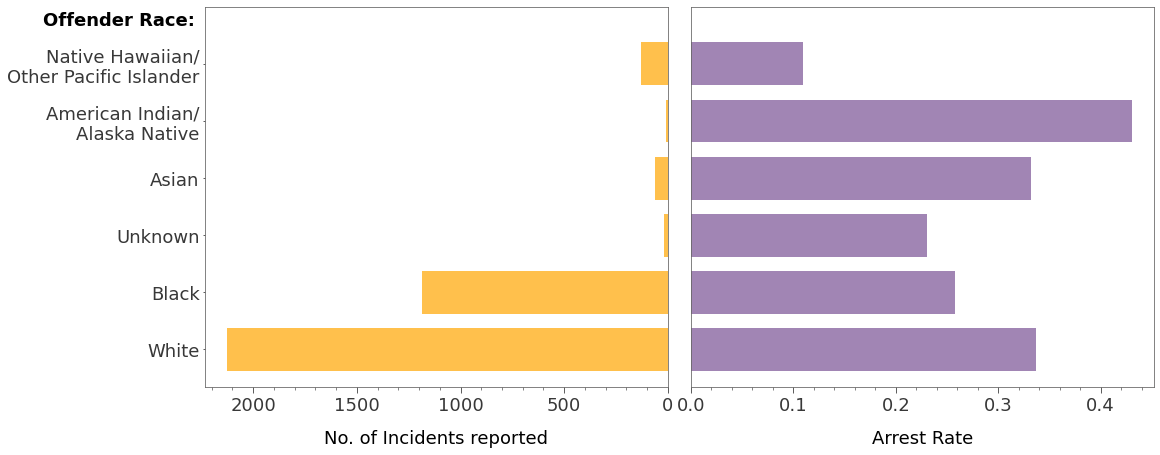

In [167]:
dat = rate_offender_race
fig, ax = plt.subplots(1,2, figsize = (17,7), gridspec_kw = {'wspace':0.05}, sharey = True)
ax[1].barh(dat.index.to_list(), dat['Arrest Rate'].astype(float), color = mycolors[0], height = 0.75, alpha = 0.7)
ax[0].barh(dat.index.to_list(), [2126, 1187, 19, 63, 7, 130], color = mycolors[3], height = 0.75, alpha = 0.7)
plt.yticks(dat.index.to_list(),['White', 'Black', 'Unknown', 'Asian', 'American Indian/\nAlaska Native', 'Native Hawaiian/\nOther Pacific Islander'])
ax[0].tick_params('y', which = 'major', length = 2)
ax[0].tick_params(which = 'minor', left = False)
ax[1].tick_params(which = 'both',labelleft = False, left = False)
ax[0].tick_params(labelsize = 18)
ax[1].tick_params(labelsize = 18)
ax[0].invert_xaxis()
ax[0].set_xlabel("No. of Incidents reported")
ax[1].set_xlabel("Arrest Rate")
ax[0].text(-0.35, .95, 'Offender Race:', transform = ax[0].transAxes, fontsize = 18, fontweight ='semibold')
ax[0].set_ylim(None, 6)
plt.savefig('Figures/AR_stacked', bbox_inches = 'tight')


The left side of the figure shows the denominator (no. of IPV-related incidents with offenders of that race) for the arrest rate one the right.

In [131]:
print("NOFFENDERS = 1 or 2") 
display(rate_victs_race)
print("(white arrest rate) - (black arrest rate) = ", \
        float(rate_victs_race.iloc[0]['Arrest Rate of Offenders']) -
          float(rate_victs_race.iloc[1]['Arrest Rate of Offenders']))

print("\n\nNOFFENDERS = 1")
display(rate_victs_race_v1)
print("(white arrest rate) - (black arrest rate) = ", \
        float(rate_victs_race_v1.iloc[0]['Arrest Rate of Offenders']) -
          float(rate_victs_race_v1.iloc[1]['Arrest Rate of Offenders']))

print("\n\nNOFFENDERS = 2")
display(rate_victs_race_v2)
print("(white arrest rate) - (black arrest rate) = ", \
        float(rate_victs_race_v2.iloc[0]['Arrest Rate of Offenders']) -
          float(rate_victs_race_v2.iloc[1]['Arrest Rate of Offenders']))

NOFFENDERS = 1 or 2


,Victim(s) Race,Arrest Rate of Offenders,
0,White,0.33761853092418737,(14313/42394)
1,Black or African American,0.24956352059155798,(4860/19474)
2,Unknown,0.34688346883468835,(128/369)
3,Victims of different races,0.3945409429280397,(159/403)
4,Asian,0.3384615384615385,(352/1040)
5,American Indian or Alaska Native,0.48148148148148145,(39/81)
6,Native Hawaiian or Other Pacific Islander,0.09141274238227147,(165/1805)


(white arrest rate) - (black arrest rate) =  0.08805501033262939


NOFFENDERS = 1


,Victim(s) Race,Arrest Rate of Offenders,
0,White,0.34588165180899405,(13929/40271)
1,Black or African American,0.25553550926685253,(4674/18291)
2,Unknown,0.3524355300859599,(123/349)
3,Victims of different races,0.3929471032745592,(156/397)
4,Asian,0.3394683026584867,(332/978)
5,American Indian or Alaska Native,0.4594594594594595,(34/74)
6,Native Hawaiian or Other Pacific Islander,0.09737156511350059,(163/1674)


(white arrest rate) - (black arrest rate) =  0.09034614254214152


NOFFENDERS = 2


,Victim(s) Race,Arrest Rate of Offenders,
0,White,0.18134715025906736,(385/2123)
1,Black or African American,0.158072696534235,(187/1183)
2,Unknown,0.3,(6/20)
3,Victims of different races,0.6666666666666666,(4/6)
4,Asian,0.3387096774193548,(21/62)
5,American Indian or Alaska Native,0.8571428571428571,(6/7)
6,Native Hawaiian or Other Pacific Islander,0.022900763358778626,(3/131)


(white arrest rate) - (black arrest rate) =  0.02327445372483236


In [132]:
print("NOFFENDERS = 1 or 2")
display(rate_offender_ethn)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_offender_ethn.iloc[1]['Arrest Rate'])-float(rate_offender_ethn.iloc[0]['Arrest Rate']))

print("\n\nNOFFENDERS = 1")
display(rate_offender_ethn_v1)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_offender_ethn_v1.iloc[1]['Arrest Rate'])-float(rate_offender_ethn_v1.iloc[0]['Arrest Rate']))

print("\n\nNOFFENDERS = 2")
display(rate_offender_ethn_v2)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_offender_ethn_v2.iloc[1]['Arrest Rate'])-float(rate_offender_ethn_v2.iloc[0]['Arrest Rate']))

NOFFENDERS = 1 or 2


,Offender Ethnicity,Arrest Rate,
0,Hispanic or Latino,0.3393224321942622,(6931/20426)
1,Not Hispanic or Latino,0.3434896191392823,(12491/36365)
2,Unknown,0.1991701244813278,(336/1687)
3,NaN,0.02299661399548533,(163/7088)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.004167186945020052


NOFFENDERS = 1


,Offender Ethnicity,Arrest Rate,
0,Hispanic or Latino,0.3483652762119504,(6798/19514)
1,Not Hispanic or Latino,0.3533199312414416,(12127/34323)
2,Unknown,0.2,(323/1615)
3,NaN,0.023852932239440898,(157/6582)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.004954655029491217


NOFFENDERS = 2


,Offender Ethnicity,Arrest Rate,
0,Hispanic or Latino,0.14583333333333334,(133/912)
1,Not Hispanic or Latino,0.178256611165524,(364/2042)
2,Unknown,0.18055555555555555,(13/72)
3,NaN,0.01383399209486166,(7/506)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.03242327783219065


In [133]:
print("NOFFENDERS = 1 or 2")
display(rate_victs_ethn)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_victs_ethn.iloc[1]['Arrest Rate of Offenders'])
      -float(rate_victs_ethn.iloc[0]['Arrest Rate of Offenders']))

print("\n\nNOFFENDERS = 1")
display(rate_victs_ethn_v1)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_victs_ethn_v1.iloc[1]['Arrest Rate of Offenders'])
      -float(rate_victs_ethn_v1.iloc[0]['Arrest Rate of Offenders']))

print("\n\nNOFFENDERS = 2")
display(rate_victs_ethn_v2)
print("(non-hispanic arrest rate) - (hispanic arrest rate) = ", \
      float(rate_victs_ethn_v2.iloc[1]['Arrest Rate of Offenders'])
      -float(rate_victs_ethn_v2.iloc[0]['Arrest Rate of Offenders']))

NOFFENDERS = 1 or 2


,Victim(s) Ethnicity,Arrest Rate of Offenders,
0,Hispanic or Latino,0.3040342765027786,(7167/23573)
1,Not Hispanic or Latino,0.30394164320450473,(11875/39070)
2,Unknown,0.28110599078341014,(488/1736)
3,Victims of different ethnicities,0.4491150442477876,(203/452)
4,NaN,0.3877551020408163,(285/735)


(non-hispanic arrest rate) - (hispanic arrest rate) =  -9.263329827385869e-05


NOFFENDERS = 1


,Victim(s) Ethnicity,Arrest Rate of Offenders,
0,Hispanic or Latino,0.311225852399181,(6992/22466)
1,Not Hispanic or Latino,0.311724961332863,(11488/36853)
2,Unknown,0.2905027932960894,(468/1611)
3,Victims of different ethnicities,0.4631336405529954,(201/434)
4,NaN,0.3880597014925373,(260/670)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.0004991089336819909


NOFFENDERS = 2


,Victim(s) Ethnicity,Arrest Rate of Offenders,
0,Hispanic or Latino,0.15898825654923215,(176/1107)
1,Not Hispanic or Latino,0.17501127649977447,(388/2217)
2,Unknown,0.168,(21/125)
3,Victims of different ethnicities,0.16666666666666666,(3/18)
4,NaN,0.4,(26/65)


(non-hispanic arrest rate) - (hispanic arrest rate) =  0.01602301995054231


<font color = purple> Summary:</font> In general, incidents with two offenders (`NOFFENDERS = 2`) have lower arrest rates than incidents with single offenders (`NOFFENDERS = 1`). The arrest rate changes relatively little for a given race between looking at the race of victims versus the race of offenders. The same is true for ethnicity of victims versus ethnicity of offenders (not much difference). **The arrest rate for incidents with black victims/offenders is lower than that for incidents with white victims/offenders.**  When looking at `NOFFENDERS = 1 or 2` and `NOFFENDERS = 1`, the disparity in arrest rates between black offenders and white offenders is greater than the disparity in arrest rates between non-hispanic offenders and hispanic offenders (interestingly, the arrest rates for hispanic and non-hispanic offenders are very similar). However, the disparity in arrest rates between non-hispanic offenders and hispanic-offenders is largest in the case `NOFFENDERS = 2` (with non-hispanic offenders have a higher rate of arrest). 

## Check data against theory: arrest rate by race (conditioned on offense type) should not vary with reporting agency

### arrest rate by race of offenders, conditioned on offense type -- all agencies

I'll look at the case of `NOFFENDERS = 1`. If there's time, I'll look at `NOFFENDERS = 2` separately.  I could compare white vs non-white offenders, but in the above tables the arrest rate for white offenders was quite similar to the arrest rate for asian offenders, which is interesting in itself. 

**New data subset**

In [134]:
IPIVOA4 = IPIVOA3[IPIVOA3['NOFFENDERS']==1]

For this task, I will need to iterate by `INCIDENT_ID`. 

In [135]:
# select incidents where NOFFENDERS = 1
selectincidents = IPIVOA4['INCIDENT_ID'].unique()
# create a list of possible offender races
race_codes =  IPIVOA4['OFFENDER_RACE_ID'].unique().tolist()
# create a list of offenses types in data subset that intersect with IPV-related offenses
selectoffns = IPIVOA4['OFFENSE_TYPE_ID'].unique().tolist()
offn_codes = list(set(selectoffns).intersection(DVoffn_codes2))

# create matrix to hold arrest rates. first fill with 0
numerator_matrix = np.zeros(shape = (len(race_codes), len(offn_codes)))
denominator_matrix = np.zeros(shape = (len(race_codes), len(offn_codes)))

n = len(selectincidents)
start_time = time.time()
for i, incident_id in enumerate(selectincidents):
    printprogress(i,n, start_time)
    incident = IPIVOA4[IPIVOA4['INCIDENT_ID']==incident_id]
    incident_offns = incident['OFFENSE_TYPE_ID'].unique() # list of offense types in incident
    offender_races = incident['OFFENDER_RACE_ID'].unique() # should be just one race (NOFFENDERS = 1)
    if len(offender_races)>1:
        print('warning: multiple offender races')
    offender_race = offender_races[0]
    # if incident offense is IPV-related offense, add 1 to denominator matrix 
    ## position in denominator matrix is determined by offender race
    for offn in incident_offns:
        if offn in offn_codes:
            denominator_matrix[race_codes.index(offender_race), offn_codes.index(offn)]+=1
            
    # if arrest occured in incident
    if incident['NARRESTS'].all() == 1:
        arrestee_races = incident[incident['ARRESTEE_ID'].notna()]['ARRESTEE_RACE_ID'].unique()
        if len(arrestee_races)>1:
            print('warning: multiple arrestee races')
        arrestee_race = arrestee_races[0]
        # find offenses for which offender was arrested 
        ## arrest_offns may be all offenses committed by the offender, or just some/one of them 
        arrest_offns = incident[incident['ARRESTEE_ID'].notna()]['OFFENSE_TYPE_ID'].unique()
        for offn in arrest_offns:
            # if arrest offense is IPV-related offense, add 1 to numerator matrix
            if offn in offn_codes: 
                numerator_matrix[race_codes.index(arrestee_race), offn_codes.index(offn)]+=1

0 % -- 0 minutes 0.001045 seconds
10 % -- 0 minutes 9.035146 seconds
20 % -- 0 minutes 19.670192 seconds
30 % -- 0 minutes 25.840931 seconds
40 % -- 0 minutes 32.922776 seconds
50 % -- 0 minutes 42.405940 seconds
60 % -- 0 minutes 53.983262 seconds
70 % -- 1 minutes 5.179956 seconds
80 % -- 1 minutes 24.055567 seconds
90 % -- 1 minutes 39.131122 seconds
100 % -- 1 minutes 54.281122 seconds


In [136]:
denominatordf = pd.DataFrame(denominator_matrix.T, columns = [drace_short[i] for i in race_codes], 
                                                  index = [doffense_types[i] for i in offn_codes], dtype = int)
denominatordf = denominatordf.style.set_caption("No. of IPV-Related Offenses").set_table_styles(tablestyles)
display(denominatordf)
numeratordf = pd.DataFrame(numerator_matrix.T, columns = [drace_short[i] for i in race_codes], 
                                               index = [doffense_types[i] for i in offn_codes], dtype = int)
numeratordf = numeratordf.style.set_caption("No. of IPV-Related Arrests").set_table_styles(tablestyles)
display(numeratordf)

## calculate ratio 
ratio_matrix = np.empty(shape=numerator_matrix.shape)
ratio_matrix[:] = np.NaN
pretty_ratio = np.empty(shape=numerator_matrix.shape, dtype = 'S10') # for display purposes
pretty_ratio[:] = ""
for i in range(len(numerator_matrix)):
    for j in range(len(numerator_matrix[i])):
        if denominator_matrix[i,j]!=0:
            ratio = numerator_matrix[i,j]/denominator_matrix[i,j]
            ratio_matrix[i,j] = ratio
            pretty_ratio[i,j] = str("%.4f"%ratio)
            if denominator_matrix[i,j]<100:
                pretty_ratio[i,j] = "%.3f"%ratio+"*"
            if denominator_matrix[i,j]<20:
                pretty_ratio[i,j] = "%.2f"%ratio+"**"
                
            
ratiodf = pd.DataFrame(pretty_ratio.T, columns = [drace_short[i] for i in race_codes], 
                                               index = [doffense_types[i] for i in offn_codes], dtype = str)
ratiodf.to_latex(buf = 'latex.txt', index = True,  longtable = False)
ratiodf = ratiodf.style.set_caption("Arrest Rate").set_table_styles(tablestyles)
display(ratiodf)
print("* = denominator < 100")
print("** = denominator < 20\n\n")

# column key
for each in race_codes:
    print(drace_short[each], '=', drace[each])
    
    

,W,B,U,A,I,P
Murder and Nonnegligent Manslaughter,48,36,0,3,0,0
Sexual Assault With An Object,34,11,0,1,0,0
Rape,545,198,9,21,1,16
Robbery,123,232,1,1,1,11
"Human Trafficking, Commercial Sex Acts",1,14,0,1,0,0
Sodomy,65,24,0,2,0,3
Intimidation,3132,2249,48,81,5,137
Simple Assault,29181,15261,309,716,64,1001
Arson,2,8,0,0,0,1
Fondling,51,7,2,1,1,2


,W,B,U,A,I,P
Murder and Nonnegligent Manslaughter,22,20,0,2,0,0
Sexual Assault With An Object,3,2,0,1,0,0
Rape,48,23,0,3,0,2
Robbery,11,24,0,0,0,2
"Human Trafficking, Commercial Sex Acts",0,0,0,0,0,0
Sodomy,2,0,0,0,0,0
Intimidation,387,185,6,9,1,2
Simple Assault,10363,4024,70,258,26,43
Arson,0,1,0,0,0,1
Fondling,6,1,0,0,0,0


,W,B,U,A,I,P
Murder and Nonnegligent Manslaughter,0.458*,0.556*,,0.67**,,
Sexual Assault With An Object,0.088*,0.18**,,1.00**,,
Rape,0.0881,0.1162,0.00**,0.143*,0.00**,0.12**
Robbery,0.0894,0.1034,0.00**,0.00**,0.00**,0.18**
"Human Trafficking, Commercial Sex Acts",0.00**,0.00**,,0.00**,,
Sodomy,0.031*,0.000*,,0.00**,,0.00**
Intimidation,0.1236,0.0823,0.125*,0.111*,0.20**,0.0146
Simple Assault,0.3551,0.2637,0.2265,0.3603,0.406*,0.0430
Arson,0.00**,0.12**,,,,1.00**
Fondling,0.118*,0.14**,0.00**,0.00**,0.00**,0.00**


* = denominator < 100
** = denominator < 20


W = White
B = Black or African American
U = Unknown
A = Asian
I = American Indian or Alaska Native
P = Native Hawaiian or Other Pacific Islander


If I want to further compare these arrest rates across reporting agency, I have to consider the low rate of occurrence among some combinations of offender race/offense type (marked with '$*$' or '$**$' in the table). Therefore, moving forward I will compare arrest rates for the two offender races having the most representation in the data -- black and white -- for the three types of crime most represented in the data -- intimidation, simple assault, and aggravated assault. 

Comparing arrest rates for black offenders versus white offenders in the last table above, it is interesting to note that the disparity is not uniform across type of offense. Compared to white offenders, Black offenders are arrested at a higher rate for murder and nonnegligent manslaughter, rape, and robbery, and at a lower rate for intimidation, simple assault, aggravated assault, and kidnapping/abduction. 

### Find percent of IPV-related incidents out of total incidents reported for a given reporting agency

Continuing with `NOFFENDERS = 1` for numerator (IPV-related incidents). New variable `IPVPERCENT`, `AGNUMINC` (denominator of percent), and `AGNUMIPV` (numerator of percent) to both *ag_incident* (will = 0% for some) and *IPVOA4* dataframes.  

In [137]:
print("number of unique reporting agencies in data subset:")
print(len(IPIVOA4['AGENCY_ID'].unique()))

print("\nnumber of unique reporting agencies (reporting at least 1 incident) in NIBRS - TX2019:")
# recall ag_incident is agencies.csv merged with NIBRS_incident.csv
print(len(ag_incident['AGENCY_ID'].unique()))

number of unique reporting agencies in data subset:
555

number of unique reporting agencies (reporting at least 1 incident) in NIBRS - TX2019:
619


In [138]:
listagencies = ag_incident['AGENCY_ID'].unique()
ag_incident['IPVPERCENT'] = -999
IPIVOA4['IPVPERCENT'] = -999
ag_incident['AGNUMINC'] = -999
IPIVOA4['AGNUMINC'] = -999
ag_incident['AGNUMIPV'] = -999
IPIVOA4['AGNUMIPV'] = -999


n = len(listagencies); start_time = time.time()
for i, agency_id in enumerate(listagencies):
    printprogress(i,n, start_time)
    percent = 0
    if agency_id in IPIVOA4['AGENCY_ID'].to_list():
        # numerator = no of unique incidents in IPV-related dataframe reported by agency_id
        numerator = len(IPIVOA4[IPIVOA4['AGENCY_ID']==agency_id]['INCIDENT_ID'].unique())
        # denominator = total no of unique incidents reported by agency_id
        denominator = len(ag_incident[ag_incident['AGENCY_ID']==agency_id]['INCIDENT_ID'].unique())
        percent = numerator/denominator*100
    IPIVOA4.loc[IPIVOA4['AGENCY_ID']==agency_id, 'IPVPERCENT'] = percent
    ag_incident.loc[ag_incident['AGENCY_ID']==agency_id, 'IPVPERCENT'] = percent
    
    IPIVOA4.loc[IPIVOA4['AGENCY_ID']==agency_id, 'AGNUMINC'] = denominator
    ag_incident.loc[ag_incident['AGENCY_ID']==agency_id, 'AGNUMINC'] = denominator
    
    IPIVOA4.loc[IPIVOA4['AGENCY_ID']==agency_id, 'AGNUMIPV'] = numerator
    ag_incident.loc[ag_incident['AGENCY_ID']==agency_id, 'AGNUMIPV'] = numerator
    
    

0 % -- 0 minutes 0.000000 seconds
10 % -- 0 minutes 4.350393 seconds
20 % -- 0 minutes 7.064785 seconds
30 % -- 0 minutes 9.619384 seconds
40 % -- 0 minutes 12.173771 seconds
50 % -- 0 minutes 14.827844 seconds
60 % -- 0 minutes 17.388038 seconds
70 % -- 0 minutes 19.872464 seconds
80 % -- 0 minutes 22.375823 seconds
90 % -- 0 minutes 25.083714 seconds
100 % -- 0 minutes 28.161834 seconds


Text(0, 0.5, 'No. of agencies')

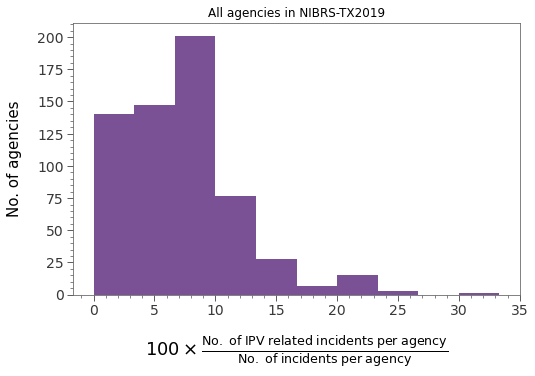

In [139]:
fig, ax = plt.subplots(figsize = (8,5))
_ = ax.hist(ag_incident[['AGENCY_ID', 'IPVPERCENT']].drop_duplicates()['IPVPERCENT'])
ax.set_title('All agencies in NIBRS-TX2019')
ax.set_xlabel(r"$100 \times \frac{\mathrm{No.\;of\;IPV\;related\;incidents\;per\;agency}}{\mathrm{No.\;of\;incidents\;per\;agency}}$",
             fontsize = 18, labelpad = 15)
ax.set_ylabel("No. of agencies", fontsize = 15, labelpad = 15)

Text(0, 0.5, 'No. of agencies')

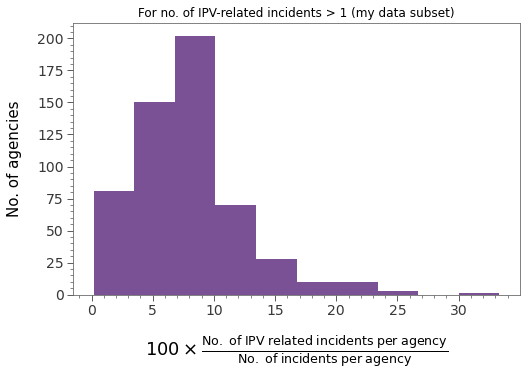

In [140]:
fig, ax = plt.subplots(figsize = (8,5))
labelopts = {'fontsize':15, 'labelpad':15}
_ = ax.hist(IPIVOA4[['AGENCY_ID', 'IPVPERCENT']].drop_duplicates()['IPVPERCENT'])
ax.set_title('For no. of IPV-related incidents > 1 (my data subset)')
ax.set_xlabel(r"$100 \times \frac{\mathrm{No.\;of\;IPV\;related\;incidents\;per\;agency}}{\mathrm{No.\;of\;incidents\;per\;agency}}$",
             fontsize = 18, labelpad = 15)
ax.set_ylabel("No. of agencies", fontsize = 15, labelpad = 15)

median 7.604562737642586
IQR 4.987425260807799
mean 7.855911726183258
st. dev. 4.541528992817615


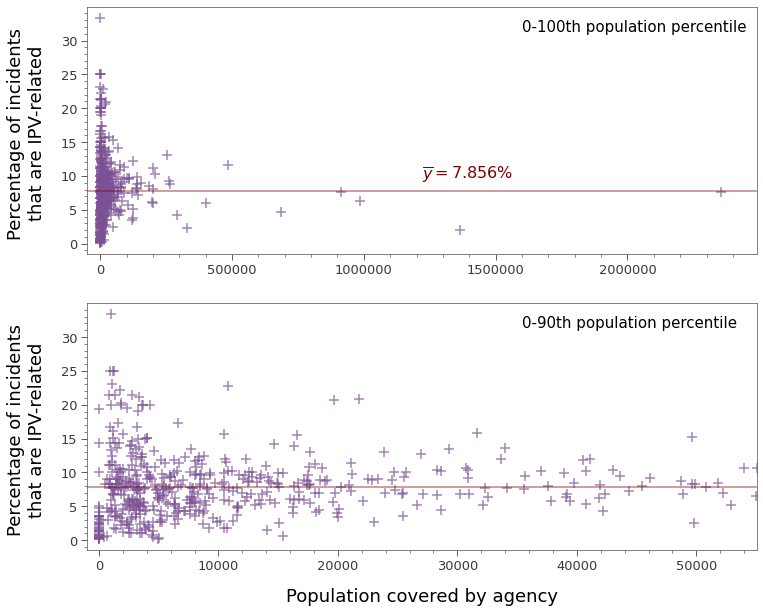

In [141]:
fig, ax = plt.subplots(2, figsize = (12,10))
dat = ag_incident[['AGENCY_ID', 'IPVPERCENT', 'POPULATION']].drop_duplicates()
dat = dat[(dat['IPVPERCENT']>0)] # equivalent to using IPVOA4, but 'POPULATION' not in IPVOA4
avg_ipvpercent = dat['IPVPERCENT'].mean()
print('median',  dat['IPVPERCENT'].median())
print('IQR', dat['IPVPERCENT'].quantile(.75)-dat['IPVPERCENT'].quantile(.25))
print('mean', avg_ipvpercent)
print('st. dev.', dat['IPVPERCENT'].std())
for axi in ax: 
    axi.tick_params(labelsize = 13)
    axi.set_ylabel("Percentage of incidents \nthat are IPV-related ", fontsize = 18, labelpad = 15)
    axi.scatter(dat['POPULATION'], dat['IPVPERCENT'], alpha = 0.7, marker = '+', s = 100)
    axi.ticklabel_format(useOffset = False, style = 'plain')
    axi.plot(np.linspace(-100000, 2e7, 3), np.linspace(1, 1, 3)*avg_ipvpercent, c = (0.5,0,0), alpha = 0.5)
ax[1].set_xlabel("Population covered by agency", fontsize = 18, labelpad = 15)
ax[0].set_xlim(-50000, 2.49e6)
ax[1].set_xlim(-1000, np.percentile(dat['POPULATION'], 90))
ax[0].text(0.65, 0.9, '0-100th population percentile', transform = ax[0].transAxes, fontsize = 15)
ax[1].text(0.65, 0.9, '0-90th population percentile', transform = ax[1].transAxes, fontsize = 15)
_ = ax[0].text(0.5, 0.3, r'$\overline{y} = $%.3f%%'%(avg_ipvpercent), transform = ax[0].transAxes, 
               fontsize = 16, c = (0.5,0,0))
#plt.savefig('Figures/IPVpercent_agencies', bbox_inches = 'tight')


In [142]:
avg_ipvpercent

7.855911726183258

The figure above shows that the percentage of incidents reported by an agency that are IPV-related tends around 7.856%, with variability decreasing among agencies as the population covered by the agency increases. The median percentage is a bit lower at 7.605%. Important to note that the above figure and calculated average were generated using the IPV-related subset of the data (that is, among agencies that reported at least one IPV-related incident). 

In [143]:
## population strongly correlated with no. of agency employees -> figure looks essentially the same

# ag_incident['NUMEMPLOYEES'] = ag_incident['PED.MALE_OFFICER+PED.MALE_CIVILIAN']+ag_incident["PED.FEMALE_CIVILIAN+PED.FEMALE_OFFICER"]
# dat = ag_incident[['AGENCY_ID', 'IPVPERCENT', "NUMEMPLOYEES"]].drop_duplicates()
# dat = dat[dat['IPVPERCENT']>0]

# fig, ax = plt.subplots()
# ax.scatter(dat['NUMEMPLOYEES'], dat['IPVPERCENT'])

**What agency had the highest percentage of IPV-related incidents? Which cover the largest populations?**

In [144]:
outlier_agency = dat[dat['IPVPERCENT']>25]['AGENCY_ID'].iloc[0]
agencycol = ['AGENCY_ID', "UCR_AGENCY_NAME", "NCIC_AGENCY_NAME", "PUB_AGENCY_NAME", "NIBRS_START_DATE", "POPULATION", 
             "POPULATION_GROUP_DESC","AGENCY_TYPE_NAME", "COUNTY_NAME", "MSA_NAME",
             "NIBRS_PARTICIPATED", "COVERED_FLAG"]
agencycol = ['AGENCY_ID', 'NCIC_AGENCY_NAME', 'NIBRS_START_DATE', 'POPULATION', 'IPVPERCENT', 'AGNUMINC', 'AGNUMIPV']

display(ag_incident[ag_incident['AGENCY_ID']==outlier_agency][agencycol].drop_duplicates())

outlier_agencies = dat[dat['POPULATION']>0.5e6]['AGENCY_ID']
display(ag_incident[ag_incident['AGENCY_ID'].isin(outlier_agencies)][agencycol].drop_duplicates())

,AGENCY_ID,NCIC_AGENCY_NAME,NIBRS_START_DATE,POPULATION,IPVPERCENT,AGNUMINC,AGNUMIPV
56481,18956,SANTA ANNA PD,01-JUN-19,1032,33.333333,6,2


,AGENCY_ID,NCIC_AGENCY_NAME,NIBRS_START_DATE,POPULATION,IPVPERCENT,AGNUMINC,AGNUMIPV
147705,19109,EL PASO PD,01-JUL-19,686793,4.632759,12131,562
411466,19711,FORT WORTH PD,01-OCT-05,915237,7.659869,46241,3542
487056,19756,AUSTIN PD,01-JAN-19,986062,6.264533,73972,4634
605575,19869,DALLAS POLICE DEPARTMENT,01-MAR-18,1363295,2.096819,90375,1895
695950,19870,HOUSTON POLICE DEPARTMENT,01-JUN-18,2355606,7.589557,202581,15375


So we see that this agency with the highest percentage had only reported 6 incidents, 2 of which were IPV-related. HPD covers the largest population, and its percentage of IPV incidents is very close to the average; Dallas PD covers the second largest population, but it has a rather lower percentage (about 2.1%). 

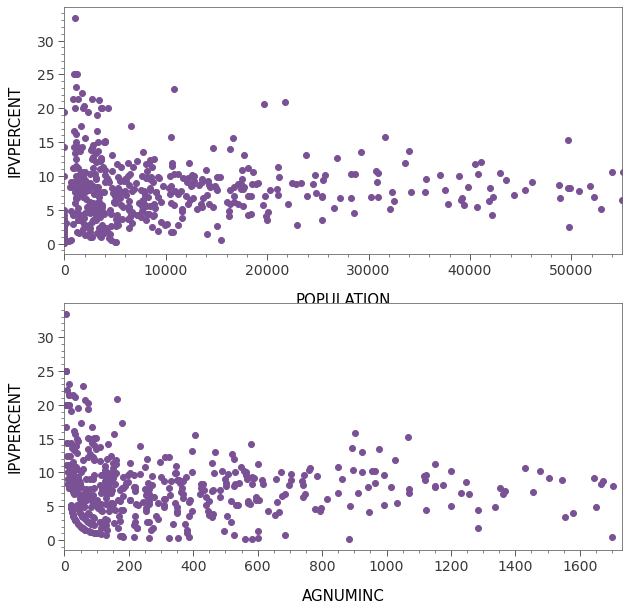

In [145]:
fig, ax = plt.subplots(2,figsize = (10,10))

xvar = 'POPULATION'
dat = ag_incident[['AGENCY_ID', 'IPVPERCENT', xvar]].drop_duplicates()
dat = dat[dat['IPVPERCENT']>0]


ax[0].scatter(dat[xvar], dat['IPVPERCENT'])
ax[0].set_xlim(0, np.percentile(dat[xvar], 90)) # cut off at 90th percentile
ax[0].set_xlabel(xvar, fontsize = 15)

xvar = 'AGNUMINC'
dat = ag_incident[['AGENCY_ID', 'IPVPERCENT', xvar]].drop_duplicates()
dat = dat[dat['IPVPERCENT']>0]

ax[1].scatter(dat[xvar], dat['IPVPERCENT'])
ax[1].set_xlim(0, np.percentile(dat[xvar], 90)) # cut off at 90th percentile
ax[1].set_xlabel(xvar, fontsize = 15)

for axi in ax:
    axi.set_ylabel('IPVPERCENT', fontsize = 15)

## Does arrest rate by race vary with reporting agency?

In [146]:
agency_numer_b = []
agency_numer_w = []

agency_denom_b = []
agency_denom_w = []

IPVpercents_b = []
IPVpercents_w = []

agency_id_b = []
agency_id_w = []
for agency_id in IPIVOA4['AGENCY_ID'].unique():
    if len(IPIVOA4[IPIVOA4['AGENCY_ID']==agency_id]['IPVPERCENT'].unique())==1:
        agIPVpercent = IPIVOA4[IPIVOA4['AGENCY_ID']==agency_id]['IPVPERCENT'].unique()[0]
    else:
        print('warning: >1 IPVPERCENT per agency')
    
    raceid = 2 # Black or African American
    denominator = len(IPIVOA4[(IPIVOA4['OFFENDER_RACE_ID']==raceid)&(IPIVOA4['AGENCY_ID']==agency_id)]\
                      ['OFFENDER_ID'].unique())
    ## number of unique arrestee IDs in the dataset with race X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_RACE_ID']==raceid)&(IPIVOA4['AGENCY_ID']==agency_id)]\
                    ['ARRESTEE_ID'].unique())
    if denominator!=0:
        agency_numer_b.append(numerator)
        agency_denom_b.append(denominator)
        IPVpercents_b.append(agIPVpercent)
        agency_id_b.append(agency_id)
        
    
    raceid = 1 # Black or African American
    denominator = len(IPIVOA4[(IPIVOA4['OFFENDER_RACE_ID']==raceid)&(IPIVOA4['AGENCY_ID']==agency_id)]\
                      ['OFFENDER_ID'].unique())
    ## number of unique arrestee IDs in the dataset with race X
    numerator = len(IPIVOA3[(IPIVOA3['ARRESTEE_RACE_ID']==raceid)&(IPIVOA4['AGENCY_ID']==agency_id)]\
                    ['ARRESTEE_ID'].unique())
    if denominator!=0:
        agency_numer_w.append(numerator)
        agency_denom_w.append(denominator)
        IPVpercents_w.append(agIPVpercent)
        agency_id_w.append(agency_id)


In [147]:
agency_numer_b = np.array(agency_numer_b)
agency_denom_b = np.array(agency_denom_b)
agency_numer_w = np.array(agency_numer_w)
agency_denom_w = np.array(agency_denom_w)
print("n agencies with at least 1 IPV-related incident", len(IPIVOA4['AGENCY_ID'].unique()))
print("n agencies in white arrest rate (no. white offenders != 0): ",len(agency_numer_w))
print("n agencies in black arrest rate (no. black offenders ! = 0): ",len(agency_numer_b))

n agencies with at least 1 IPV-related incident 555
n agencies in white arrest rate (no. white offenders != 0):  535
n agencies in black arrest rate (no. black offenders ! = 0):  359


In [148]:
df_agency_w = pd.DataFrame(np.array([agency_id_w, IPVpercents_w, agency_numer_w, agency_denom_w, agency_numer_w/agency_denom_w]).T, 
                          columns = ['AGENCY_ID', 'IPVPERCENT', 'NUMERATOR_W', 'DENOMINATOR_W', 'ARRESTRATE_W'])
df_agency_b = pd.DataFrame(np.array([agency_id_b, IPVpercents_b, agency_numer_b, agency_denom_b, agency_numer_b/agency_denom_b]).T, 
                          columns = ['AGENCY_ID', 'IPVPERCENT', 'NUMERATOR_B', 'DENOMINATOR_B', 'ARRESTRATE_B'])

df_agency = pd.merge(df_agency_w, df_agency_b, on = ['AGENCY_ID', 'IPVPERCENT'])

mean 0.019107444594287808
median 0.0236900780379041
st.dev 0.30030715758513976
IQR 0.29105780421569905


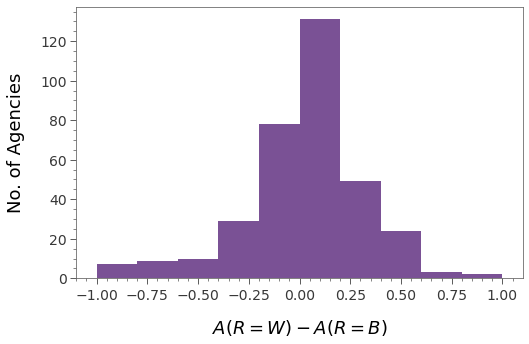

In [149]:
temp = df_agency['ARRESTRATE_W']-df_agency['ARRESTRATE_B']
plt.hist(temp)
plt.xlabel('$A(R=W)-A(R=B)$')
plt.ylabel('No. of Agencies')
print('mean', temp.mean())
print('median', temp.median())
print('st.dev', temp.std())
print('IQR', temp.quantile(0.75)-temp.quantile(0.25))
#plt.savefig("Figures/AR_agency", bbox_inches = 'tight')

Large spread, but note that some of this may be the result of an agency having few reported incidents overall (i.e. 1 reported incident with a black offender where an arrest took place and no reported incidents with white offenders could yield a difference in arrest rates of -1). I'll look at this by setting a lower threshold that defines the mininum number of reported incidents an agency must have to be included in the histogram/summary statistics. 

In [150]:
df_agency = pd.merge(df_agency, IPIVOA4[['AGENCY_ID', 'AGNUMINC']].drop_duplicates(), on = 'AGENCY_ID')

In [151]:
low_threshold = 500
subset = df_agency[(df_agency['AGNUMINC']>=low_threshold)]

In [152]:
len(subset)

165

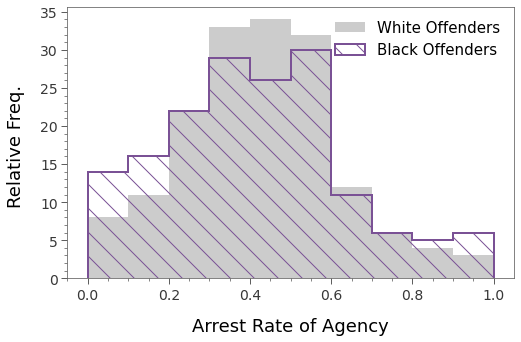

In [153]:
plt.hist(subset['ARRESTRATE_W'], density = False, color = 'k', alpha = 0.2, label = "White Offenders")
plt.hist(subset['ARRESTRATE_B'], density = False, histtype = 'step', hatch = '\\', lw = 2, label = 'Black Offenders')
plt.xlabel('Arrest Rate of Agency')
plt.ylabel("Relative Freq. ")
plt.legend()

mean 0.02425440890751641
median 0.02605633802816898
st dev 0.18206733581603107
IQR 0.14357971705611186


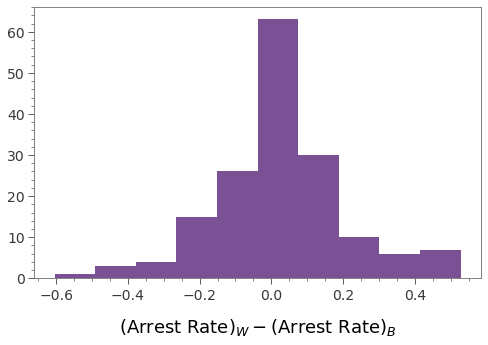

In [154]:
plt.hist(subset['ARRESTRATE_W']-subset['ARRESTRATE_B'])
plt.xlabel('(Arrest Rate)$_{W}-$(Arrest Rate)$_{B}$')
print("mean", (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).mean())
print("median", (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).median())
print("st dev", (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).std())
print("IQR", (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).quantile(.75)-
            (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).quantile(.25))

Of course, the summary statistics above depend on the value chosen for the lower threshold. 

Lower threshold		n	mean		 median		 st. dev	 IQR	
1			342	0.019107	 0.023690	 0.300307	 0.291058
250			228	0.025375	 0.027357	 0.244817	 0.184264
500			165	0.024254	 0.026056	 0.182067	 0.143580
1000			92	0.011251	 0.021605	 0.130171	 0.105156
3000			36	0.008625	 0.031743	 0.090796	 0.074078
5000			26	0.013512	 0.034501	 0.101957	 0.065276


(-300.0, 5300.0)

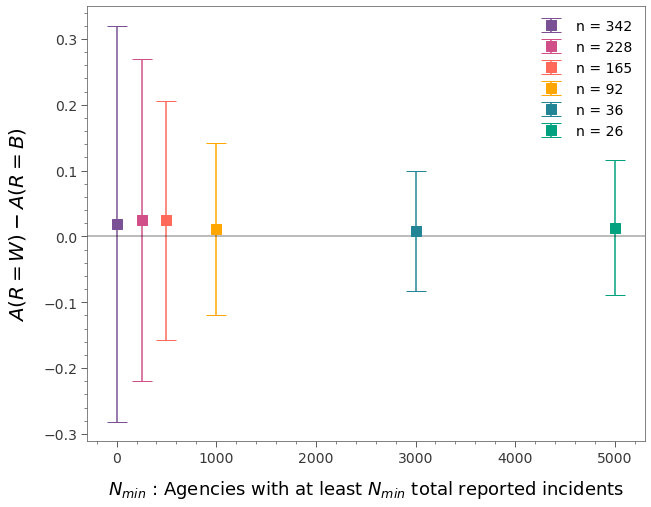

In [155]:
fig, ax = plt.subplots(figsize = (10,8))

print("%s\t\t%s\t%s\t\t %s\t\t %s\t %s\t"%('Lower threshold', 'n', 'mean', 'median', 'st. dev', 'IQR'))
threshold_values = [1,250, 500, 1000, 3000, 5000]
for lower_threshold_value in threshold_values:
    subset = df_agency[(df_agency['AGNUMINC']>=lower_threshold_value)]
    n = len(subset)
    mean = (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).mean()
    median = (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).median()
    std = (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).std()
    IQR = (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).quantile(.75)-\
            (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).quantile(.25)
    print("%d\t\t\t%d\t%f\t %f\t %f\t %f"%(lower_threshold_value, n, mean, median, std, IQR))
    plt.errorbar(x = lower_threshold_value, y = mean, yerr = std, label = 'n = %d'%n, fmt = 's', 
                markersize = 10, capsize = 10.0)
    
ax.plot(np.linspace(-400,5500,10), np.linspace(0,0,10), c = 'k', alpha = 0.35)
ax.legend(framealpha = 0, fontsize = 14)
ax.set_xlabel('$N_{min}$ : Agencies with at least $N_{min}$ total reported incidents', fontsize = 18, labelpad = 13)
_ = ax.set_ylabel('$A(R=W)-A(R=B)$', fontsize = 20, labelpad = 15)
ax.set_xlim(-300, 5300)
#plt.savefig('Figures/ARdiff_subsets', bbox_inches = 'tight')    

(-300.0, 5300.0)

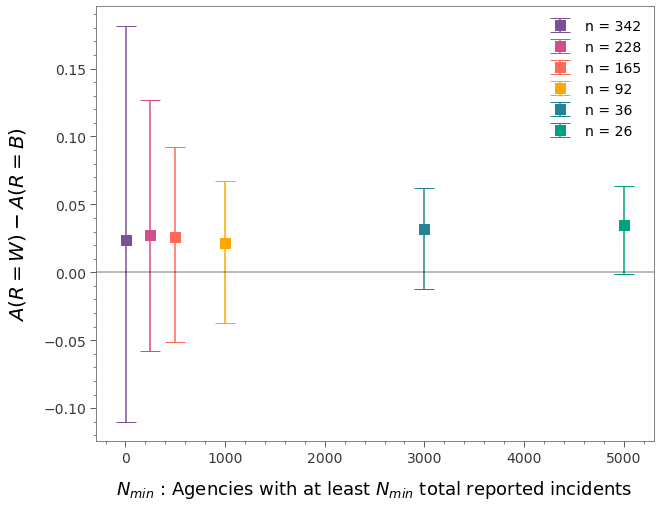

In [156]:
####### version using median/IQR ##########
fig, ax = plt.subplots(figsize = (10,8))

#print("%s\t\t%s\t%s\t\t %s\t\t %s\t %s\t"%('Lower threshold', 'n', 'mean', 'median', 'st. dev', 'IQR'))
threshold_values = [1,250, 500, 1000, 3000, 5000]
for lower_threshold_value in threshold_values:
    subset = df_agency[(df_agency['AGNUMINC']>=lower_threshold_value)]
    n = len(subset)
    diff = subset['ARRESTRATE_W']-subset['ARRESTRATE_B']
    mean = (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).mean()
    median = (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).median()
    std = (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).std()
    IQR = (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).quantile(.75)-\
            (subset['ARRESTRATE_W']-subset['ARRESTRATE_B']).quantile(.25)
    
    upperr = diff.quantile(0.75)-median
    lowerr = median-diff.quantile(0.25)
    #print("%d\t\t\t%d\t%f\t %f\t %f\t %f"%(lower_threshold_value, n, mean, median, std, IQR))
    plt.errorbar(x = lower_threshold_value, y = median, yerr = np.array([[lowerr],[upperr]]), label = 'n = %d'%n, fmt = 's', 
                markersize = 10, capsize = 10.0)
    
ax.plot(np.linspace(-400,5500,10), np.linspace(0,0,10), c = 'k', alpha = 0.35)
ax.legend(framealpha = 0, fontsize = 14)
ax.set_xlabel('$N_{min}$ : Agencies with at least $N_{min}$ total reported incidents', fontsize = 18, labelpad = 13)
_ = ax.set_ylabel('$A(R=W)-A(R=B)$', fontsize = 20, labelpad = 15)
ax.set_xlim(-300, 5300)
#plt.savefig('Figures/ARdiff_subsets_median', bbox_inches = 'tight')

## Does arrest rate by race AND offense vary with reporting agency?

Find two n X p matrices for n agencies and p offenses: one white offender matrix and one black offender matrix. 

In [157]:
agencyids = IPIVOA4['AGENCY_ID'].unique().tolist()
n = len(agencyids)
# look at three most common offense types in data 
three_offns = [doffensetype_to_code[i] for i in ['Simple Assault', 'Aggravated Assault', 'Intimidation']]
p = len(three_offns)

Wmatrix_numer = np.zeros(shape = (n,p))
Bmatrix_numer = np.zeros(shape = (n,p))

Wmatrix_denom = np.zeros(shape = (n,p))
Bmatrix_denom = np.zeros(shape = (n,p))

niters = len(IPIVOA4['INCIDENT_ID'].unique())
start_time = time.time()
for i, incident_id in enumerate(IPIVOA4['INCIDENT_ID'].unique()):
    printprogress(i, niters, start_time)
    incident = IPIVOA4[IPIVOA4['INCIDENT_ID']==incident_id]

    offender_races = incident['OFFENDER_RACE_ID'].unique() # should be just one race (NOFFENDERS = 1)
    if len(offender_races)>1:
        print('warning: multiple offender races')
    offender_race = offender_races[0]
    agency_ids = incident['AGENCY_ID'].unique() # should be just one 
    if len(agency_ids)>1:
        print('warning: multiple agency ids')
    agency_id = agency_ids[0]
    incident_offns = incident['OFFENSE_TYPE_ID'].unique() # list of offense types in incident

    # white offenders
    if offender_race == 1:
        for offn in incident_offns:
            if offn in three_offns:
                Wmatrix_denom[agencyids.index(agency_id), three_offns.index(offn)]+=1
        # if arrest
        if incident['NARRESTS'].all() == 1:
            arrestee_races = incident[incident['ARRESTEE_ID'].notna()]['ARRESTEE_RACE_ID'].unique()
            if len(arrestee_races)>1:
                print('warning: multiple arrestee races')
            arrestee_race = arrestee_races[0]
            arrest_offns = incident[incident['ARRESTEE_ID'].notna()]['OFFENSE_TYPE_ID'].unique()
            for offn in arrest_offns:
                # if arrest offense is IPV-related offense, add 1 to numerator matrix
                if offn in three_offns: 
                    Wmatrix_numer[agencyids.index(agency_id), three_offns.index(offn)]+=1
    # black offenders
    if offender_race == 2:
        for offn in incident_offns:
            if offn in three_offns:
                Bmatrix_denom[agencyids.index(agency_id), three_offns.index(offn)]+=1
        # if arrest
        if incident['NARRESTS'].all() == 1:
            arrestee_races = incident[incident['ARRESTEE_ID'].notna()]['ARRESTEE_RACE_ID'].unique()
            if len(arrestee_races)>1:
                print('warning: multiple arrestee races')
            arrestee_race = arrestee_races[0]
            arrest_offns = incident[incident['ARRESTEE_ID'].notna()]['OFFENSE_TYPE_ID'].unique()
            for offn in arrest_offns:
                # if arrest offense is IPV-related offense, add 1 to numerator matrix
                if offn in three_offns: 
                    Bmatrix_numer[agencyids.index(agency_id), three_offns.index(offn)]+=1       

0 % -- 0 minutes 0.000000 seconds
10 % -- 0 minutes 10.410837 seconds
20 % -- 0 minutes 20.030617 seconds
30 % -- 0 minutes 31.986264 seconds
40 % -- 0 minutes 44.926912 seconds
50 % -- 1 minutes 1.068084 seconds
60 % -- 1 minutes 21.196398 seconds
70 % -- 1 minutes 30.960114 seconds
80 % -- 1 minutes 42.719642 seconds
90 % -- 1 minutes 52.645993 seconds
100 % -- 2 minutes 9.243126 seconds


In [158]:
Wmatrix_ratio = np.empty(shape = Wmatrix_numer.shape)
Wmatrix_ratio[:] = np.NaN

Bmatrix_ratio = np.empty(shape = Bmatrix_numer.shape)
Bmatrix_ratio[:] = np.NaN

diff_ratio = np.empty(shape = Wmatrix_numer.shape)
diff_ratio[:] = np.NaN

for i in range(len(Wmatrix_numer)):
    for j in range(len(Wmatrix_numer[i])):
        if Wmatrix_denom[i,j]!=0:
            Wmatrix_ratio[i,j] = Wmatrix_numer[i,j]/Wmatrix_denom[i,j]     
        if Bmatrix_denom[i,j]!=0:
            Bmatrix_ratio[i,j] = Bmatrix_numer[i,j]/Bmatrix_denom[i,j]
        if (Wmatrix_denom[i,j]!=0) & (Bmatrix_denom[i,j]!=0):
            diff_ratio[i,j] = Wmatrix_ratio[i,j] - Bmatrix_ratio[i,j]



In [159]:
columns = columns = ['AGENCY_ID']+[doffense_types[i] for i in three_offns]
Wdf = pd.DataFrame(np.vstack([agencyids, Wmatrix_ratio.T]).T, columns = columns)
Bdf = pd.DataFrame(np.vstack([agencyids, Bmatrix_ratio.T]).T, columns = columns)
diffdf = pd.DataFrame(np.vstack([agencyids, diff_ratio.T]).T, columns = columns)

        Offense Type	n	mean		median		st.dev		IQR
      Simple Assault	555	0.021904	0.017727	0.322988	0.249094
  Aggravated Assault	555	0.071154	0.034058	0.423440	0.459125
        Intimidation	555	-0.008811	0.000000	0.373993	0.209133


Text(0, 0.5, 'No. of agencies')

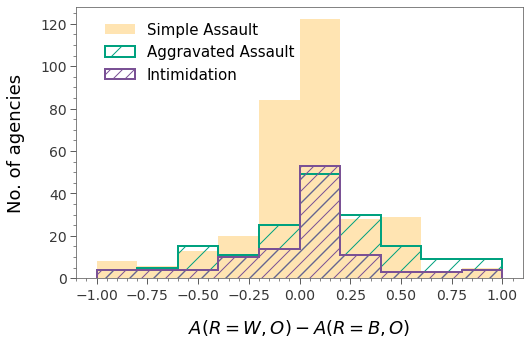

In [160]:
hatches = [None, '/', '//']
histtype = ['stepfilled', 'step', 'step']
alphas = [0.3, 1, 1]
colors = [mycolors[i] for i in [3,5,0]]
print('%20s\tn\tmean\t\tmedian\t\tst.dev\t\tIQR'%('Offense Type'))
for i, offense in enumerate(['Simple Assault', 'Aggravated Assault', 'Intimidation']):
    plt.hist(diffdf[offense], label = offense, color = colors[i], histtype = histtype[i], lw = 2, hatch = hatches[i], alpha = alphas[i])
    print("%20s\t%d\t%f\t%f\t%f\t%f"%(offense, len(diffdf[offense]),diffdf[offense].mean(), 
                                    diffdf[offense].median(), diffdf[offense].std(), 
                                     diffdf[offense].quantile(0.75)-diffdf[offense].quantile(0.25)))
plt.legend(loc = (0.05, 0.7))
plt.xlabel("$A(R=W, O)-A(R=B, O)$")
plt.ylabel("No. of agencies")
#plt.savefig("Figures/ARO_agency", bbox_inches = 'tight')

Still have large spread. I will look at difference using threshold as before. 

In [161]:
diffdf = pd.merge(diffdf, IPIVOA4[['AGENCY_ID', 'AGNUMINC']].drop_duplicates(), on = 'AGENCY_ID')

             Offense	Threshold		n	mean		 median		 st. dev	 IQR	
      Simple Assault	4			555	0.021904	 0.017727	 0.322988	 0.249094
  Aggravated Assault	4			555	0.071154	 0.034058	 0.423440	 0.459125
        Intimidation	4			555	-0.008811	 0.000000	 0.373993	 0.209133
      Simple Assault	26			500	0.023625	 0.017801	 0.322667	 0.249948
  Aggravated Assault	26			500	0.071154	 0.034058	 0.423440	 0.459125
        Intimidation	26			500	-0.008811	 0.000000	 0.373993	 0.209133
      Simple Assault	74			417	0.034092	 0.023342	 0.298893	 0.239234
  Aggravated Assault	74			417	0.069293	 0.038462	 0.422403	 0.464814
        Intimidation	74			417	-0.008811	 0.000000	 0.373993	 0.209133
      Simple Assault	216			278	0.032116	 0.022727	 0.259074	 0.200000
  Aggravated Assault	216			278	0.051341	 0.038462	 0.400412	 0.466667
        Intimidation	216			278	-0.020115	 0.000000	 0.369402	 0.215865
      Simple Assault	609			139	0.035581	 0.026961	 0.187530	 0.160577
  Aggravated Assault	609			139	0.0

(2, 41909.90000000026)

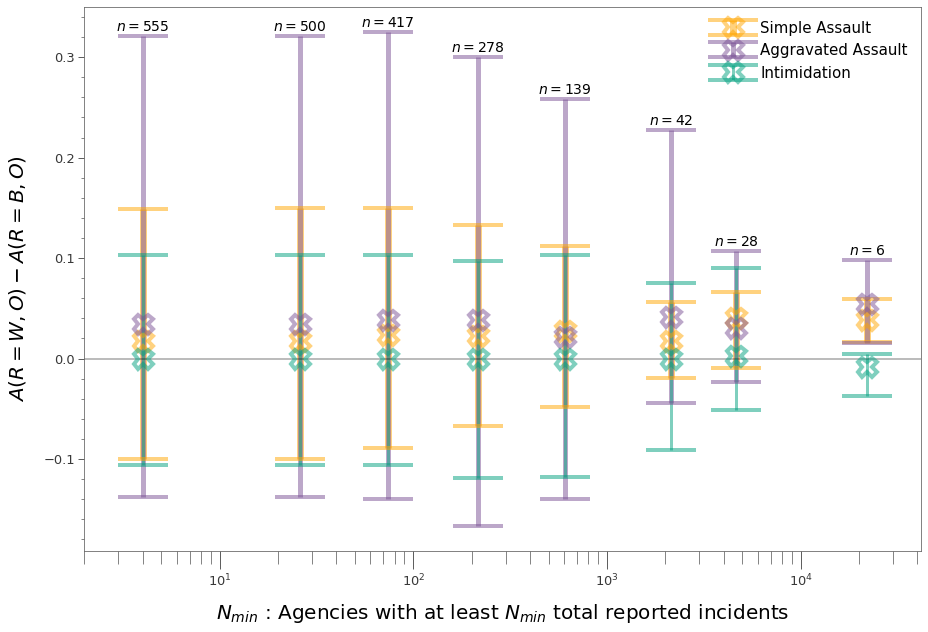

In [162]:
fig, ax = plt.subplots(figsize = (15,10))
shapes = ['X', 'X', 'X']
colors = [mycolors[i] for i in [7,0,5]]
lws = [7, 5, 3]
alphas = [0.5,0.5,0.5]
print("%20s\t%s\t\t%s\t%s\t\t %s\t\t %s\t %s\t"%('Offense','Threshold', 'n', 'mean', 'median', 'st. dev', 'IQR'))
agnumincs = diffdf['AGNUMINC']
#threshold_values = [1,250, 500, 1000, 3000, 5000]
threshold_values = [agnumincs.quantile(i) for i in [0,0.1, 0.25, .50,.75, 0.925, 0.95, 0.99]]
for j, lower_threshold_value in enumerate(threshold_values):
    for i, offense in enumerate(['Simple Assault', 'Aggravated Assault', 'Intimidation']):
        subset = diffdf[(diffdf['AGNUMINC']>=lower_threshold_value)][offense]
        n = len(subset)
        mean = subset.mean(); median = subset.median(); std = subset.std()
        IQR = subset.quantile(0.75)-subset.quantile(0.25)
        upperr = subset.quantile(0.75)-median
        lowerr = median-subset.quantile(0.25)
        print("%20s\t%d\t\t\t%d\t%f\t %f\t %f\t %f"%(offense, lower_threshold_value, n, mean, median, std, IQR))
        
        label = None
        if j == 0:
            label = offense
        ax.errorbar(x = lower_threshold_value, y = median, yerr = [[lowerr],[upperr]], 
                     fmt = shapes[i], color = colors[i], lw = lws[i], 
                    alpha  = alphas[i], markersize = 19, capsize = 25, capthick = 3, label = label, 
                    mew = 4, markerfacecolor = 'None')
        if i == 1:
            plt.text(lower_threshold_value, subset.quantile(0.75)+.005, '$n = %d$'%n, fontsize = 14, 
                    horizontalalignment = 'center')
    
ax.plot(np.linspace(-400,50000,10), np.linspace(0,0,10), c = 'k', alpha = 0.35)
ax.legend(framealpha = 0, fontsize = 15)
ax.set_xlabel('$N_{min}$ : Agencies with at least $N_{min}$ total reported incidents', fontsize = 20, labelpad = 13)
_ = ax.set_ylabel('$A(R=W, O)-A(R=B, O)$', fontsize = 20, labelpad = 15)
ax.tick_params(labelsize = 13)
ax.set_xscale('log')
ax.tick_params('x', which = 'minor', length = 13)
ax.tick_params('x', which = 'major', length = 18)
ax.set_xlim(2,max(threshold_values)+20000)
#ax.set_xlim(-300, max(threshold_values)+500)
#plt.savefig("Figures/AROdiff_subsets")

In [163]:
total_run_time = time.time() - global_start_time
print(" Notebook run time -- %d minutes %f seconds"%(math.floor(total_run_time/60),total_run_time%60))

 Notebook run time -- 41 minutes 43.105246 seconds


In [164]:
from platform import python_version

python_version()

'3.8.5'